In [10]:
import os
import scipy
import imageio
import numpy as np
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import PIL
import imghdr
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes

In [17]:
def get_YOLO_boxing(File_name, original_x, original_y, nx, ny):
    """
    Imports YOLO boxing coordinates from csv file

    Arguments:
    File_name -- file path
    original_x -- number of horizontal pixels of the photo
    original_y --- number of vertical pixels of the photo
    nx --- number of horizontal grid cells
    ny --- number of vertical gird cells

    Returns: 
    image_id -- library contains (pc,x,y,w,h,grid_x,grid_y)
    pc --- probability score
    x --- x coord of box top left cornor in a grid cell
    y --- y coord of box top left cornor in a grid cell
    w --- width of box
    h --- height of box
    grid_x --- x coord of the grid cell
    gird_y --- y coord of the grid cell
    """
    
    bb_list = []
    with open(File_name) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            bb_list.append(row)

    bb_list.pop(0)

    image_id = {} 
    for j in range(1,9767):
        image_id[j] = []
        image_id[j].append(np.array([0,0,0,0,0,0,0]))

    for i in range(len(bb_list)):
        for j in range(len(bb_list[i])):
            #print(bb_list[i][j])
            bb_list[i][j] = float(bb_list[i][j])
            bb_list[i][0] = int(bb_list[i][0])
            
    for idy in tqdm(image_id.keys()):
        num = []
        for image in bb_list:
            if image[0] == idy:
                xc = image[1]+image[3]/2
                yc = image[2]+image[4]/2
                wc = image[3]
                hc = image[4]
                grid_x = np.floor(xc*nx/original_x)
                grid_y = np.floor(yc*ny/original_y)
                x = xc*nx/original_x - np.floor(xc*nx/original_x)
                y = yc*ny/original_y - np.floor(yc*ny/original_y)
                w = wc / (original_x/nx)
                h = hc / (original_y/ny)
                num.append(np.array([1, x,y,w,h,grid_x,grid_y]))
                image_id[idy]= num

    return image_id

In [18]:
my_dict = get_YOLO_boxing("./bounding_boxes.csv", 720, 480, 15,10)


In [13]:
type(my_dict[18])

list

In [14]:
def YOLO_output_layer(image_id,nx,ny,a=1):
    """
    convert output of get_YOLO_boxing into (nx,ny,a*5) flatten layer

    Arguments:
    image_id -- library contains (pc,x,y,w,h,grid_x,grid_y)
    nx --- number of horizontal grid cells
    ny --- number of vertical gird cells
    a --- number of anchor boxes

    Returns: 
    output_layer -- (nx,ny,a*5) flatten layer

    """
    num_of_box = len(image_id)
    output_layer = np.zeros((nx,ny,a*5))
    for i in range(num_of_box):
        if image_id[i][0] != 0:
            grid_x = int(image_id[i][5])
            grid_y = int(image_id[i][6])
            output_layer[grid_x][grid_y] = image_id[i][0:5]
    return output_layer
    

In [15]:
def bb_drawing(image_path, yolo_output_layer, original_x = 720, original_y = 480, colors = [(255,0,0)]):
    
    nx,ny,_ = yolo_output_layer.shape
    image = PIL.Image.open(image_path)
    out_boxes = [];
    out_scores = [];
    out_classes = [];
    for i in range(nx):
        for j in range(ny):
            if yolo_output_layer[i][j][0] != 0:
                out_scores.append(yolo_output_layer[i][j][0])
                yolo_x = yolo_output_layer[i][j][1]
                yolo_y = yolo_output_layer[i][j][2]
                yolo_w = yolo_output_layer[i][j][3]
                yolo_h = yolo_output_layer[i][j][4]
                box_x1 = i*(original_x/nx)+yolo_x*(original_x/nx) - (yolo_w*(original_x/nx)/2)
                box_y1 = j*(original_y/ny)+yolo_y*(original_y/ny) - (yolo_h*(original_y/ny)/2)
                box_x2 = box_x1 + yolo_w*(original_x/nx)
                box_y2 = box_y1 + yolo_h*(original_y/ny)
                out_boxes.append(np.array([box_y1, box_x1, box_y2, box_x2]))
                out_classes.append(0)
    #print(box_x1)
    #print(box_y1)
    #print(box_x2)
    #print(box_y2)
    #out_scores = [0.9]
    #out_boxes = [[yolo_x*nx,yolo_y*ny,original_x,original_y]]
    #out_classes = [0]
    class_names = ['rock']
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_path), quality=90)
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("out", image_path))
    imshow(output_image)

In [7]:
test_output = YOLO_output_layer(my_dict[18],15,10)
test_output.shape

(15, 10, 5)

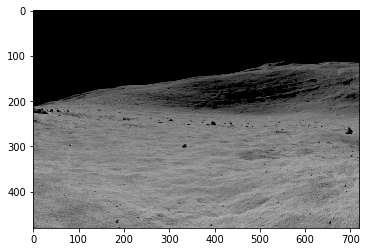

In [8]:
bb_drawing('./images/render0018.png',test_output)

In [ ]:
#def batch_boxing(file_path, start_frame, end_frame, original_x, original_y):
#    frame_range = np.arange(start_frame, end_frame+1)
#    for i in tqdm(len(frame_range)):
#        num = str(frame_range)
#        num.zfill(4)
#        file_name = file_path+num
start_frame = 1
end_frame = 9766
file_path = "./images/render"
file_ext = ".png"
frame_range = np.arange(start_frame, end_frame+1)
range_length = int(len(frame_range))
for i in tqdm(range(range_length)):
    frame_num = frame_range[i]
    file_name = file_path+str(frame_num).zfill(4)+file_ext
    print(frame_num)
    print(file_name)
    bb_drawing(file_name, YOLO_output_layer(my_dict[frame_num],15,10))

1
./images/render0001.png
rock 1.00 (279, 193) (335, 231)
2
./images/render0002.png
rock 1.00 (600, 152) (720, 282)
3
./images/render0003.png
rock 1.00 (6, 47) (96, 134)
4
./images/render0004.png
5
./images/render0005.png
rock 1.00 (240, 102) (343, 123)
6
./images/render0006.png
rock 1.00 (683, 125) (717, 151)
7
./images/render0007.png
rock 1.00 (1, 271) (261, 410)
8
./images/render0008.png
9
./images/render0009.png
rock 1.00 (4, 278) (67, 314)
10
./images/render0010.png
11
./images/render0011.png
rock 1.00 (677, 77) (698, 98)
rock 1.00 (443, 76) (518, 150)
12
./images/render0012.png
13
./images/render0013.png
rock 1.00 (437, 202) (464, 225)
rock 1.00 (328, 189) (364, 220)
rock 1.00 (1, 177) (30, 218)
14
./images/render0014.png
15
./images/render0015.png
rock 1.00 (572, 269) (671, 301)
rock 1.00 (504, 218) (566, 270)
rock 1.00 (385, 167) (505, 253)
rock 1.00 (219, 447) (453, 480)
rock 1.00 (12, 129) (247, 301)
16
./images/render0016.png
rock 1.00 (328, 178) (406, 269)
rock 1.00 (230, 1

rock 1.00 (122, 45) (266, 110)
rock 1.00 (203, 4) (269, 27)
rock 1.00 (2, 54) (126, 116)
rock 1.00 (1, 56) (24, 102)
rock 1.00 (1, 9) (39, 55)
94
./images/render0094.png
95
./images/render0095.png
rock 1.00 (681, 94) (720, 160)
rock 1.00 (92, 61) (134, 84)
rock 1.00 (1, 156) (33, 217)
96
./images/render0096.png
rock 1.00 (181, 5) (215, 33)
97
./images/render0097.png
98
./images/render0098.png
rock 1.00 (98, 104) (141, 133)
99
./images/render0099.png
100
./images/render0100.png
rock 1.00 (167, 26) (204, 63)
101
./images/render0101.png
rock 1.00 (553, 163) (585, 193)
102
./images/render0102.png
rock 1.00 (20, 414) (51, 444)
103
./images/render0103.png
rock 1.00 (1, 97) (68, 167)
104
./images/render0104.png
105
./images/render0105.png
rock 1.00 (249, 119) (292, 148)
rock 1.00 (193, 152) (275, 224)
106
./images/render0106.png
107
./images/render0107.png
rock 1.00 (475, 118) (511, 142)
rock 1.00 (422, 97) (476, 128)
rock 1.00 (167, 20) (242, 76)
108
./images/render0108.png
109
./images/rend

./images/render0188.png
rock 1.00 (355, 188) (464, 255)
189
./images/render0189.png
190
./images/render0190.png
rock 1.00 (229, 212) (318, 327)
rock 1.00 (195, 246) (245, 287)
rock 1.00 (58, 195) (129, 259)
rock 1.00 (10, 1) (69, 124)
191
./images/render0191.png
rock 1.00 (354, 189) (428, 237)
192
./images/render0192.png
rock 1.00 (305, 75) (336, 98)
rock 1.00 (228, 73) (291, 108)
rock 1.00 (9, 243) (71, 273)
193
./images/render0193.png
194
./images/render0194.png
195
./images/render0195.png
rock 1.00 (391, 207) (477, 247)
rock 1.00 (291, 164) (352, 186)
196
./images/render0196.png
rock 1.00 (597, 203) (628, 227)
197
./images/render0197.png
198
./images/render0198.png
rock 1.00 (490, 155) (522, 182)
199
./images/render0199.png
200
./images/render0200.png
rock 1.00 (612, 120) (681, 144)
rock 1.00 (566, 59) (591, 88)
rock 1.00 (421, 61) (498, 86)
rock 1.00 (153, 38) (206, 85)
rock 1.00 (58, 64) (121, 129)
201
./images/render0201.png
202
./images/render0202.png
rock 1.00 (268, 87) (311, 1

rock 1.00 (396, 34) (440, 78)
rock 1.00 (170, 113) (264, 157)
rock 1.00 (164, 50) (228, 93)
rock 1.00 (63, 128) (200, 226)
rock 1.00 (1, 252) (113, 379)
292
./images/render0292.png
rock 1.00 (665, 75) (698, 99)
rock 1.00 (633, 76) (670, 110)
rock 1.00 (406, 125) (557, 197)
293
./images/render0293.png
294
./images/render0294.png
295
./images/render0295.png
rock 1.00 (78, 292) (715, 480)
rock 1.00 (148, 46) (192, 73)
rock 1.00 (1, 117) (32, 150)
296
./images/render0296.png
rock 1.00 (400, 204) (428, 229)
rock 1.00 (148, 163) (215, 201)
297
./images/render0297.png
rock 1.00 (312, 166) (398, 198)
rock 1.00 (255, 209) (381, 254)
rock 1.00 (188, 292) (255, 345)
298
./images/render0298.png
299
./images/render0299.png
rock 1.00 (481, 133) (528, 163)
300
./images/render0300.png
301
./images/render0301.png
302
./images/render0302.png
rock 1.00 (628, 92) (681, 122)
rock 1.00 (299, 300) (403, 374)
rock 1.00 (253, 363) (301, 429)
303
./images/render0303.png
rock 1.00 (243, 245) (288, 279)
rock 1.00

./images/render0378.png
rock 1.00 (681, 1) (720, 35)
rock 1.00 (535, 39) (629, 65)
rock 1.00 (507, 1) (543, 28)
rock 1.00 (324, 58) (394, 92)
rock 1.00 (10, 351) (92, 447)
rock 1.00 (82, 240) (106, 262)
379
./images/render0379.png
rock 1.00 (40, 137) (139, 225)
380
./images/render0380.png
rock 1.00 (397, 161) (585, 327)
rock 1.00 (222, 102) (429, 226)
381
./images/render0381.png
382
./images/render0382.png
rock 1.00 (385, 42) (470, 94)
rock 1.00 (345, 67) (378, 93)
rock 1.00 (138, 139) (183, 181)
rock 1.00 (89, 190) (122, 215)
rock 1.00 (56, 228) (112, 267)
rock 1.00 (68, 209) (94, 231)
rock 1.00 (1, 250) (47, 301)
383
./images/render0383.png
rock 1.00 (460, 126) (487, 154)
384
./images/render0384.png
rock 1.00 (689, 174) (720, 197)
rock 1.00 (613, 118) (663, 170)
rock 1.00 (571, 100) (615, 153)
rock 1.00 (503, 79) (578, 145)
385
./images/render0385.png
386
./images/render0386.png
rock 1.00 (303, 136) (329, 157)
rock 1.00 (211, 110) (250, 139)
387
./images/render0387.png
rock 1.00 (621

rock 1.00 (642, 260) (700, 299)
rock 1.00 (438, 171) (537, 279)
rock 1.00 (486, 146) (549, 212)
rock 1.00 (217, 81) (361, 176)
rock 1.00 (188, 70) (241, 112)
rock 1.00 (1, 117) (181, 190)
rock 1.00 (1, 28) (67, 69)
474
./images/render0474.png
475
./images/render0475.png
rock 1.00 (512, 3) (692, 185)
rock 1.00 (350, 88) (632, 353)
rock 1.00 (186, 249) (338, 314)
rock 1.00 (208, 193) (269, 239)
rock 1.00 (162, 278) (211, 315)
rock 1.00 (88, 251) (166, 333)
476
./images/render0476.png
477
./images/render0477.png
478
./images/render0478.png
rock 1.00 (32, 287) (114, 317)
479
./images/render0479.png
480
./images/render0480.png
rock 1.00 (440, 100) (487, 130)
rock 1.00 (184, 202) (214, 224)
rock 1.00 (1, 249) (53, 316)
481
./images/render0481.png
rock 1.00 (570, 125) (720, 250)
rock 1.00 (586, 104) (635, 136)
rock 1.00 (517, 136) (574, 169)
rock 1.00 (359, 111) (393, 140)
rock 1.00 (298, 99) (358, 149)
rock 1.00 (196, 103) (272, 168)
rock 1.00 (143, 132) (167, 156)
rock 1.00 (98, 166) (172, 

rock 1.00 (36, 189) (62, 214)
553
./images/render0553.png
554
./images/render0554.png
rock 1.00 (374, 128) (442, 173)
555
./images/render0555.png
556
./images/render0556.png
rock 1.00 (260, 341) (282, 368)
557
./images/render0557.png
558
./images/render0558.png
rock 1.00 (377, 41) (507, 93)
rock 1.00 (318, 19) (373, 75)
rock 1.00 (204, 84) (254, 114)
rock 1.00 (163, 125) (193, 146)
559
./images/render0559.png
rock 1.00 (690, 52) (720, 130)
rock 1.00 (697, 1) (720, 34)
rock 1.00 (564, 55) (636, 125)
rock 1.00 (418, 203) (479, 253)
rock 1.00 (299, 246) (342, 281)
rock 1.00 (220, 262) (332, 375)
rock 1.00 (139, 403) (172, 438)
rock 1.00 (102, 382) (165, 450)
rock 1.00 (61, 396) (110, 463)
rock 1.00 (30, 440) (55, 468)
560
./images/render0560.png
rock 1.00 (501, 103) (542, 146)
rock 1.00 (364, 31) (394, 54)
561
./images/render0561.png
562
./images/render0562.png
563
./images/render0563.png
rock 1.00 (333, 293) (423, 344)
564
./images/render0564.png
565
./images/render0565.png
rock 1.00 (69

rock 1.00 (233, 187) (274, 218)
rock 1.00 (73, 289) (344, 468)
rock 1.00 (91, 163) (235, 302)
rock 1.00 (40, 403) (77, 442)
rock 1.00 (50, 279) (100, 309)
645
./images/render0645.png
rock 1.00 (394, 209) (416, 232)
rock 1.00 (357, 225) (381, 248)
646
./images/render0646.png
rock 1.00 (630, 100) (693, 172)
rock 1.00 (564, 119) (603, 144)
rock 1.00 (530, 156) (604, 203)
rock 1.00 (521, 123) (564, 149)
rock 1.00 (279, 166) (594, 337)
rock 1.00 (407, 69) (500, 151)
rock 1.00 (322, 83) (355, 113)
rock 1.00 (132, 134) (225, 161)
647
./images/render0647.png
648
./images/render0648.png
rock 1.00 (500, 164) (720, 480)
649
./images/render0649.png
650
./images/render0650.png
rock 1.00 (1, 170) (359, 480)
rock 1.00 (139, 38) (181, 63)
rock 1.00 (36, 22) (186, 96)
651
./images/render0651.png
rock 1.00 (685, 83) (706, 104)
rock 1.00 (312, 169) (357, 199)
rock 1.00 (182, 240) (230, 261)
rock 1.00 (180, 207) (212, 239)
rock 1.00 (132, 218) (184, 258)
652
./images/render0652.png
rock 1.00 (516, 114) (5

rock 1.00 (486, 117) (520, 140)
737
./images/render0737.png
rock 1.00 (585, 217) (720, 386)
rock 1.00 (464, 158) (516, 187)
738
./images/render0738.png
739
./images/render0739.png
rock 1.00 (158, 314) (235, 350)
rock 1.00 (62, 302) (103, 332)
740
./images/render0740.png
741
./images/render0741.png
rock 1.00 (610, 136) (682, 181)
rock 1.00 (208, 211) (290, 239)
rock 1.00 (186, 268) (211, 297)
rock 1.00 (146, 213) (176, 235)
rock 1.00 (21, 208) (137, 291)
742
./images/render0742.png
rock 1.00 (590, 60) (650, 108)
rock 1.00 (467, 141) (618, 217)
rock 1.00 (425, 146) (469, 188)
rock 1.00 (220, 189) (448, 331)
rock 1.00 (281, 79) (364, 115)
rock 1.00 (189, 78) (229, 112)
rock 1.00 (48, 226) (301, 366)
rock 1.00 (1, 435) (152, 480)
743
./images/render0743.png
rock 1.00 (23, 205) (80, 235)
744
./images/render0744.png
rock 1.00 (299, 147) (360, 174)
rock 1.00 (203, 162) (241, 191)
rock 1.00 (104, 230) (160, 261)
745
./images/render0745.png
rock 1.00 (569, 187) (672, 220)
rock 1.00 (294, 206) (

rock 1.00 (225, 160) (541, 328)
rock 1.00 (1, 212) (103, 266)
830
./images/render0830.png
rock 1.00 (399, 193) (422, 217)
rock 1.00 (160, 310) (212, 345)
831
./images/render0831.png
rock 1.00 (695, 39) (719, 67)
rock 1.00 (1, 269) (170, 418)
832
./images/render0832.png
833
./images/render0833.png
rock 1.00 (627, 20) (649, 41)
rock 1.00 (361, 53) (392, 86)
834
./images/render0834.png
835
./images/render0835.png
rock 1.00 (681, 378) (720, 400)
836
./images/render0836.png
rock 1.00 (358, 249) (382, 270)
837
./images/render0837.png
838
./images/render0838.png
839
./images/render0839.png
rock 1.00 (657, 212) (720, 308)
rock 1.00 (642, 210) (676, 252)
rock 1.00 (589, 208) (644, 251)
rock 1.00 (285, 225) (330, 256)
840
./images/render0840.png
rock 1.00 (160, 272) (195, 296)
841
./images/render0841.png
rock 1.00 (697, 134) (720, 178)
842
./images/render0842.png
rock 1.00 (149, 364) (720, 480)
rock 1.00 (396, 318) (481, 366)
rock 1.00 (260, 247) (309, 273)
rock 1.00 (21, 272) (130, 332)
843
./i

./images/render0926.png
rock 1.00 (366, 246) (407, 278)
rock 1.00 (64, 89) (93, 110)
927
./images/render0927.png
928
./images/render0928.png
rock 1.00 (685, 262) (714, 292)
rock 1.00 (585, 346) (720, 406)
929
./images/render0929.png
rock 1.00 (679, 271) (720, 297)
930
./images/render0930.png
931
./images/render0931.png
932
./images/render0932.png
rock 1.00 (286, 65) (310, 88)
933
./images/render0933.png
rock 1.00 (685, 4) (720, 32)
rock 1.00 (415, 2) (480, 48)
rock 1.00 (383, 25) (418, 53)
rock 1.00 (246, 104) (297, 128)
rock 1.00 (108, 122) (181, 153)
rock 1.00 (161, 70) (199, 91)
rock 1.00 (1, 124) (64, 213)
934
./images/render0934.png
rock 1.00 (369, 219) (404, 255)
935
./images/render0935.png
rock 1.00 (428, 179) (549, 231)
rock 1.00 (415, 216) (502, 257)
rock 1.00 (287, 128) (429, 199)
rock 1.00 (209, 109) (245, 143)
936
./images/render0936.png
rock 1.00 (383, 46) (470, 90)
rock 1.00 (297, 86) (351, 107)
rock 1.00 (1, 85) (133, 298)
937
./images/render0937.png
938
./images/render0

rock 1.00 (352, 152) (445, 185)
rock 1.00 (363, 102) (415, 143)
rock 1.00 (313, 120) (379, 172)
rock 1.00 (296, 110) (320, 132)
rock 1.00 (145, 202) (316, 265)
rock 1.00 (207, 149) (239, 172)
rock 1.00 (117, 166) (161, 190)
rock 1.00 (1, 199) (79, 254)
1020
./images/render1020.png
rock 1.00 (642, 269) (712, 291)
rock 1.00 (553, 197) (638, 243)
rock 1.00 (395, 330) (591, 480)
rock 1.00 (437, 177) (465, 199)
rock 1.00 (291, 194) (396, 266)
rock 1.00 (145, 219) (263, 268)
rock 1.00 (160, 185) (201, 213)
rock 1.00 (119, 238) (147, 265)
rock 1.00 (117, 194) (161, 219)
rock 1.00 (40, 187) (148, 234)
1021
./images/render1021.png
rock 1.00 (615, 237) (638, 260)
1022
./images/render1022.png
1023
./images/render1023.png
1024
./images/render1024.png
rock 1.00 (95, 310) (121, 337)
1025
./images/render1025.png
1026
./images/render1026.png
rock 1.00 (356, 94) (418, 143)
1027
./images/render1027.png
1028
./images/render1028.png
rock 1.00 (542, 153) (657, 197)
rock 1.00 (1, 219) (59, 257)
1029
./image

rock 1.00 (431, 37) (573, 202)
rock 1.00 (262, 135) (311, 166)
rock 1.00 (213, 146) (264, 193)
rock 1.00 (126, 275) (181, 308)
rock 1.00 (100, 303) (133, 331)
rock 1.00 (65, 284) (100, 323)
1111
./images/render1111.png
rock 1.00 (113, 210) (196, 250)
1112
./images/render1112.png
1113
./images/render1113.png
1114
./images/render1114.png
rock 1.00 (485, 51) (578, 121)
rock 1.00 (285, 107) (353, 130)
1115
./images/render1115.png
1116
./images/render1116.png
rock 1.00 (506, 87) (720, 480)
rock 1.00 (282, 11) (320, 56)
rock 1.00 (168, 38) (237, 113)
rock 1.00 (133, 91) (183, 163)
rock 1.00 (72, 266) (188, 404)
rock 1.00 (114, 107) (137, 133)
rock 1.00 (68, 212) (103, 235)
rock 1.00 (1, 372) (29, 429)
1117
./images/render1117.png
1118
./images/render1118.png
rock 1.00 (546, 194) (596, 216)
rock 1.00 (543, 165) (568, 188)
rock 1.00 (422, 215) (486, 284)
rock 1.00 (273, 260) (328, 311)
rock 1.00 (49, 384) (146, 436)
rock 1.00 (101, 343) (143, 370)
rock 1.00 (11, 363) (64, 398)
1119
./images/re

./images/render1191.png
rock 1.00 (366, 146) (391, 176)
1192
./images/render1192.png
1193
./images/render1193.png
rock 1.00 (641, 231) (675, 253)
1194
./images/render1194.png
rock 1.00 (669, 23) (698, 45)
1195
./images/render1195.png
rock 1.00 (238, 234) (439, 335)
1196
./images/render1196.png
rock 1.00 (410, 60) (506, 97)
1197
./images/render1197.png
rock 1.00 (172, 46) (198, 68)
rock 1.00 (63, 422) (129, 480)
rock 1.00 (1, 388) (73, 480)
1198
./images/render1198.png
rock 1.00 (649, 219) (720, 296)
1199
./images/render1199.png
1200
./images/render1200.png
rock 1.00 (1, 234) (69, 293)
1201
./images/render1201.png
rock 1.00 (603, 133) (647, 180)
rock 1.00 (436, 80) (504, 108)
rock 1.00 (293, 39) (322, 64)
1202
./images/render1202.png
rock 1.00 (627, 268) (720, 377)
rock 1.00 (638, 156) (708, 233)
rock 1.00 (501, 192) (648, 237)
rock 1.00 (288, 275) (630, 428)
1203
./images/render1203.png
rock 1.00 (671, 149) (698, 175)
rock 1.00 (568, 129) (607, 164)
rock 1.00 (182, 44) (215, 85)
1204
.

rock 1.00 (331, 79) (378, 109)
rock 1.00 (309, 53) (338, 74)
rock 1.00 (156, 25) (198, 47)
1286
./images/render1286.png
rock 1.00 (316, 179) (379, 221)
rock 1.00 (113, 207) (143, 238)
rock 1.00 (1, 234) (96, 289)
1287
./images/render1287.png
rock 1.00 (16, 293) (46, 315)
1288
./images/render1288.png
rock 1.00 (379, 306) (524, 421)
rock 1.00 (287, 158) (425, 223)
rock 1.00 (238, 55) (281, 77)
rock 1.00 (194, 158) (286, 207)
rock 1.00 (171, 41) (199, 63)
rock 1.00 (12, 171) (103, 208)
1289
./images/render1289.png
rock 1.00 (229, 192) (283, 219)
rock 1.00 (1, 212) (53, 276)
1290
./images/render1290.png
rock 1.00 (30, 81) (58, 124)
1291
./images/render1291.png
1292
./images/render1292.png
1293
./images/render1293.png
rock 1.00 (171, 55) (215, 77)
rock 1.00 (25, 56) (46, 89)
1294
./images/render1294.png
rock 1.00 (30, 1) (207, 160)
1295
./images/render1295.png
rock 1.00 (643, 380) (720, 461)
rock 1.00 (666, 352) (720, 399)
rock 1.00 (690, 305) (720, 333)
rock 1.00 (643, 331) (691, 356)
rock

rock 1.00 (1, 92) (66, 150)
1377
./images/render1377.png
rock 1.00 (424, 162) (450, 185)
rock 1.00 (146, 136) (200, 177)
1378
./images/render1378.png
rock 1.00 (686, 1) (720, 38)
rock 1.00 (271, 23) (462, 112)
rock 1.00 (241, 91) (270, 115)
rock 1.00 (49, 177) (224, 268)
1379
./images/render1379.png
rock 1.00 (668, 179) (705, 207)
rock 1.00 (567, 176) (632, 208)
rock 1.00 (452, 223) (525, 245)
rock 1.00 (392, 189) (454, 225)
rock 1.00 (85, 260) (217, 329)
1380
./images/render1380.png
rock 1.00 (462, 1) (695, 179)
rock 1.00 (354, 114) (416, 164)
rock 1.00 (319, 59) (367, 112)
rock 1.00 (279, 97) (318, 127)
rock 1.00 (243, 193) (296, 220)
rock 1.00 (255, 86) (294, 112)
rock 1.00 (206, 212) (244, 242)
rock 1.00 (178, 126) (207, 170)
rock 1.00 (167, 192) (203, 214)
rock 1.00 (116, 195) (160, 236)
rock 1.00 (1, 360) (126, 480)
1381
./images/render1381.png
rock 1.00 (658, 222) (699, 243)
rock 1.00 (606, 258) (660, 284)
rock 1.00 (615, 203) (662, 239)
rock 1.00 (521, 242) (546, 266)
rock 1.00

1474
./images/render1474.png
rock 1.00 (487, 217) (526, 244)
rock 1.00 (327, 295) (367, 331)
rock 1.00 (140, 394) (165, 417)
1475
./images/render1475.png
rock 1.00 (467, 176) (494, 210)
1476
./images/render1476.png
1477
./images/render1477.png
1478
./images/render1478.png
rock 1.00 (341, 136) (373, 162)
1479
./images/render1479.png
1480
./images/render1480.png
rock 1.00 (104, 159) (209, 214)
1481
./images/render1481.png
rock 1.00 (354, 1) (403, 42)
rock 1.00 (120, 97) (151, 121)
1482
./images/render1482.png
rock 1.00 (164, 242) (231, 273)
rock 1.00 (73, 240) (115, 275)
1483
./images/render1483.png
rock 1.00 (97, 1) (261, 94)
1484
./images/render1484.png
rock 1.00 (647, 451) (720, 480)
rock 1.00 (579, 343) (639, 386)
rock 1.00 (318, 186) (396, 278)
rock 1.00 (289, 181) (321, 202)
rock 1.00 (170, 117) (225, 168)
rock 1.00 (125, 257) (229, 306)
rock 1.00 (112, 130) (170, 169)
rock 1.00 (1, 284) (178, 480)
1485
./images/render1485.png
rock 1.00 (601, 152) (650, 184)
rock 1.00 (449, 189) (5

rock 1.00 (269, 184) (311, 206)
rock 1.00 (227, 277) (286, 301)
rock 1.00 (215, 182) (260, 220)
1571
./images/render1571.png
rock 1.00 (542, 187) (647, 221)
rock 1.00 (467, 94) (549, 183)
rock 1.00 (426, 127) (470, 148)
rock 1.00 (237, 223) (396, 274)
rock 1.00 (159, 137) (194, 160)
rock 1.00 (1, 202) (39, 233)
1572
./images/render1572.png
rock 1.00 (516, 9) (555, 34)
rock 1.00 (461, 1) (518, 40)
rock 1.00 (354, 19) (394, 48)
1573
./images/render1573.png
1574
./images/render1574.png
rock 1.00 (406, 14) (509, 74)
rock 1.00 (317, 28) (457, 84)
rock 1.00 (210, 48) (240, 71)
rock 1.00 (116, 64) (162, 89)
rock 1.00 (35, 68) (68, 100)
rock 1.00 (1, 89) (24, 110)
1575
./images/render1575.png
rock 1.00 (631, 73) (720, 134)
1576
./images/render1576.png
rock 1.00 (1, 146) (113, 204)
1577
./images/render1577.png
rock 1.00 (656, 1) (720, 28)
rock 1.00 (440, 1) (509, 31)
rock 1.00 (259, 60) (340, 82)
rock 1.00 (178, 116) (256, 151)
rock 1.00 (198, 31) (230, 64)
rock 1.00 (89, 104) (134, 128)
rock 1

./images/render1659.png
1660
./images/render1660.png
1661
./images/render1661.png
1662
./images/render1662.png
rock 1.00 (480, 160) (530, 188)
1663
./images/render1663.png
rock 1.00 (483, 83) (536, 128)
1664
./images/render1664.png
rock 1.00 (574, 156) (720, 202)
rock 1.00 (167, 364) (283, 446)
rock 1.00 (6, 392) (167, 480)
1665
./images/render1665.png
rock 1.00 (1, 51) (41, 76)
1666
./images/render1666.png
rock 1.00 (614, 237) (695, 274)
rock 1.00 (501, 159) (570, 215)
rock 1.00 (309, 129) (392, 164)
rock 1.00 (229, 129) (266, 153)
rock 1.00 (81, 112) (152, 145)
1667
./images/render1667.png
1668
./images/render1668.png
rock 1.00 (226, 177) (265, 219)
1669
./images/render1669.png
rock 1.00 (219, 266) (310, 291)
rock 1.00 (1, 354) (44, 381)
1670
./images/render1670.png
1671
./images/render1671.png
rock 1.00 (1, 239) (123, 272)
rock 1.00 (1, 185) (25, 223)
1672
./images/render1672.png
rock 1.00 (624, 198) (720, 275)
rock 1.00 (532, 261) (624, 282)
rock 1.00 (286, 296) (320, 318)
rock 1.0

rock 1.00 (36, 79) (93, 119)
rock 1.00 (1, 53) (26, 86)
1758
./images/render1758.png
rock 1.00 (604, 100) (669, 134)
rock 1.00 (482, 12) (539, 50)
rock 1.00 (284, 25) (318, 51)
rock 1.00 (138, 101) (209, 124)
rock 1.00 (113, 75) (139, 97)
1759
./images/render1759.png
rock 1.00 (163, 1) (366, 89)
rock 1.00 (6, 129) (99, 170)
rock 1.00 (40, 40) (97, 84)
1760
./images/render1760.png
1761
./images/render1761.png
1762
./images/render1762.png
rock 1.00 (138, 179) (179, 208)
rock 1.00 (99, 186) (137, 209)
rock 1.00 (76, 126) (114, 179)
1763
./images/render1763.png
rock 1.00 (653, 138) (698, 166)
rock 1.00 (590, 139) (647, 178)
rock 1.00 (462, 161) (509, 196)
rock 1.00 (283, 264) (341, 289)
rock 1.00 (42, 234) (261, 424)
1764
./images/render1764.png
1765
./images/render1765.png
rock 1.00 (633, 248) (720, 276)
rock 1.00 (540, 177) (648, 266)
rock 1.00 (257, 401) (575, 480)
rock 1.00 (32, 254) (385, 479)
1766
./images/render1766.png
1767
./images/render1767.png
rock 1.00 (347, 102) (382, 138)
ro

1838
./images/render1838.png
rock 1.00 (645, 258) (687, 299)
rock 1.00 (574, 236) (615, 270)
rock 1.00 (421, 157) (489, 213)
rock 1.00 (2, 170) (453, 480)
rock 1.00 (1, 397) (82, 480)
1839
./images/render1839.png
1840
./images/render1840.png
rock 1.00 (689, 225) (720, 254)
rock 1.00 (566, 126) (615, 163)
rock 1.00 (485, 97) (526, 126)
rock 1.00 (395, 77) (485, 129)
rock 1.00 (377, 68) (401, 92)
rock 1.00 (316, 115) (415, 139)
rock 1.00 (29, 271) (617, 480)
rock 1.00 (264, 42) (303, 80)
rock 1.00 (211, 50) (267, 82)
rock 1.00 (100, 58) (172, 90)
rock 1.00 (18, 65) (63, 91)
1841
./images/render1841.png
rock 1.00 (284, 127) (324, 169)
1842
./images/render1842.png
1843
./images/render1843.png
1844
./images/render1844.png
rock 1.00 (645, 271) (720, 319)
rock 1.00 (590, 195) (614, 219)
rock 1.00 (113, 192) (225, 216)
1845
./images/render1845.png
1846
./images/render1846.png
rock 1.00 (30, 337) (237, 465)
1847
./images/render1847.png
rock 1.00 (184, 253) (226, 297)
rock 1.00 (173, 274) (208, 

rock 1.00 (566, 44) (627, 114)
rock 1.00 (51, 37) (95, 70)
rock 1.00 (1, 42) (35, 75)
rock 1.00 (20, 18) (55, 40)
1935
./images/render1935.png
1936
./images/render1936.png
rock 1.00 (179, 214) (220, 244)
rock 1.00 (158, 179) (187, 206)
rock 1.00 (106, 186) (145, 219)
rock 1.00 (4, 268) (67, 294)
rock 1.00 (35, 214) (56, 235)
1937
./images/render1937.png
rock 1.00 (611, 159) (720, 343)
1938
./images/render1938.png
rock 1.00 (1, 184) (37, 228)
1939
./images/render1939.png
rock 1.00 (594, 224) (676, 248)
1940
./images/render1940.png
rock 1.00 (677, 222) (720, 263)
rock 1.00 (575, 144) (669, 205)
rock 1.00 (305, 243) (472, 312)
rock 1.00 (262, 147) (326, 179)
rock 1.00 (109, 156) (143, 180)
1941
./images/render1941.png
rock 1.00 (530, 59) (567, 82)
rock 1.00 (450, 59) (488, 87)
rock 1.00 (249, 131) (314, 153)
1942
./images/render1942.png
rock 1.00 (99, 373) (147, 439)
rock 1.00 (29, 418) (67, 456)
1943
./images/render1943.png
rock 1.00 (325, 173) (414, 227)
rock 1.00 (3, 261) (105, 317)
19

./images/render2025.png
rock 1.00 (151, 55) (189, 76)
rock 1.00 (1, 87) (47, 115)
2026
./images/render2026.png
rock 1.00 (278, 4) (379, 35)
2027
./images/render2027.png
2028
./images/render2028.png
rock 1.00 (419, 267) (557, 318)
rock 1.00 (300, 240) (329, 262)
rock 1.00 (182, 284) (271, 312)
rock 1.00 (112, 208) (153, 231)
rock 1.00 (1, 288) (96, 386)
2029
./images/render2029.png
2030
./images/render2030.png
rock 1.00 (38, 184) (81, 211)
rock 1.00 (35, 171) (63, 193)
2031
./images/render2031.png
rock 1.00 (143, 149) (344, 348)
2032
./images/render2032.png
rock 1.00 (172, 108) (198, 137)
rock 1.00 (1, 242) (28, 291)
rock 1.00 (17, 150) (45, 190)
2033
./images/render2033.png
2034
./images/render2034.png
rock 1.00 (163, 145) (206, 171)
rock 1.00 (1, 153) (73, 199)
rock 1.00 (11, 125) (51, 152)
2035
./images/render2035.png
rock 1.00 (529, 164) (589, 193)
rock 1.00 (394, 232) (448, 255)
rock 1.00 (108, 421) (229, 480)
rock 1.00 (1, 374) (70, 414)
2036
./images/render2036.png
rock 1.00 (629

./images/render2116.png
2117
./images/render2117.png
rock 1.00 (126, 1) (179, 22)
2118
./images/render2118.png
rock 1.00 (519, 118) (546, 139)
2119
./images/render2119.png
rock 1.00 (507, 220) (625, 250)
rock 1.00 (242, 203) (280, 245)
rock 1.00 (46, 227) (99, 272)
2120
./images/render2120.png
rock 1.00 (541, 196) (605, 219)
rock 1.00 (553, 159) (598, 190)
rock 1.00 (239, 259) (277, 283)
rock 1.00 (183, 261) (235, 298)
rock 1.00 (61, 274) (168, 355)
2121
./images/render2121.png
rock 1.00 (5, 104) (38, 149)
2122
./images/render2122.png
rock 1.00 (592, 252) (693, 339)
rock 1.00 (1, 331) (284, 471)
2123
./images/render2123.png
rock 1.00 (599, 202) (657, 238)
rock 1.00 (534, 105) (582, 140)
rock 1.00 (439, 23) (469, 50)
rock 1.00 (343, 1) (386, 22)
2124
./images/render2124.png
2125
./images/render2125.png
rock 1.00 (143, 112) (175, 138)
2126
./images/render2126.png
2127
./images/render2127.png
2128
./images/render2128.png
2129
./images/render2129.png
rock 1.00 (618, 299) (675, 334)
rock 1.

./images/render2209.png
2210
./images/render2210.png
2211
./images/render2211.png
2212
./images/render2212.png
rock 1.00 (95, 106) (143, 133)
rock 1.00 (1, 89) (28, 119)
2213
./images/render2213.png
rock 1.00 (687, 331) (720, 359)
2214
./images/render2214.png
rock 1.00 (1, 128) (79, 333)
2215
./images/render2215.png
rock 1.00 (7, 272) (81, 297)
2216
./images/render2216.png
rock 1.00 (595, 64) (666, 132)
rock 1.00 (27, 110) (50, 135)
2217
./images/render2217.png
2218
./images/render2218.png
2219
./images/render2219.png
2220
./images/render2220.png
rock 1.00 (312, 106) (406, 132)
rock 1.00 (110, 107) (203, 130)
rock 1.00 (17, 95) (73, 121)
2221
./images/render2221.png
2222
./images/render2222.png
rock 1.00 (295, 68) (396, 93)
rock 1.00 (1, 52) (55, 79)
2223
./images/render2223.png
rock 1.00 (1, 320) (71, 383)
rock 1.00 (19, 233) (73, 282)
2224
./images/render2224.png
rock 1.00 (569, 191) (638, 236)
rock 1.00 (592, 170) (619, 191)
2225
./images/render2225.png
2226
./images/render2226.png


rock 1.00 (82, 198) (145, 223)
2304
./images/render2304.png
2305
./images/render2305.png
2306
./images/render2306.png
rock 1.00 (391, 240) (435, 267)
rock 1.00 (227, 247) (274, 284)
rock 1.00 (114, 256) (150, 286)
2307
./images/render2307.png
rock 1.00 (406, 1) (504, 59)
rock 1.00 (115, 44) (170, 80)
2308
./images/render2308.png
2309
./images/render2309.png
2310
./images/render2310.png
2311
./images/render2311.png
rock 1.00 (641, 1) (720, 91)
rock 1.00 (587, 61) (647, 115)
rock 1.00 (490, 145) (531, 172)
rock 1.00 (447, 156) (493, 201)
rock 1.00 (397, 157) (432, 180)
rock 1.00 (307, 210) (384, 250)
rock 1.00 (362, 159) (392, 187)
rock 1.00 (88, 322) (154, 361)
rock 1.00 (23, 365) (123, 441)
2312
./images/render2312.png
2313
./images/render2313.png
rock 1.00 (322, 110) (351, 136)
2314
./images/render2314.png
rock 1.00 (683, 416) (720, 480)
rock 1.00 (21, 219) (117, 249)
rock 1.00 (1, 193) (62, 230)
2315
./images/render2315.png
rock 1.00 (412, 221) (442, 247)
rock 1.00 (265, 285) (331, 3

rock 1.00 (518, 297) (562, 318)
rock 1.00 (459, 292) (517, 336)
rock 1.00 (173, 320) (235, 349)
rock 1.00 (1, 299) (37, 324)
2418
./images/render2418.png
2419
./images/render2419.png
rock 1.00 (681, 208) (705, 233)
rock 1.00 (630, 198) (662, 222)
2420
./images/render2420.png
2421
./images/render2421.png
2422
./images/render2422.png
2423
./images/render2423.png
rock 1.00 (698, 99) (720, 130)
rock 1.00 (327, 79) (425, 101)
rock 1.00 (61, 192) (238, 288)
rock 1.00 (106, 58) (233, 135)
2424
./images/render2424.png
2425
./images/render2425.png
rock 1.00 (570, 112) (600, 141)
rock 1.00 (441, 99) (579, 194)
rock 1.00 (353, 208) (498, 246)
rock 1.00 (340, 154) (391, 194)
rock 1.00 (262, 150) (327, 190)
rock 1.00 (163, 157) (257, 212)
rock 1.00 (108, 194) (188, 258)
rock 1.00 (18, 354) (143, 404)
rock 1.00 (1, 234) (40, 285)
2426
./images/render2426.png
2427
./images/render2427.png
2428
./images/render2428.png
rock 1.00 (386, 385) (666, 480)
2429
./images/render2429.png
rock 1.00 (250, 122) (31

rock 1.00 (492, 19) (521, 51)
2509
./images/render2509.png
rock 1.00 (663, 243) (693, 266)
rock 1.00 (632, 243) (665, 265)
rock 1.00 (519, 332) (619, 356)
rock 1.00 (540, 256) (563, 278)
rock 1.00 (476, 336) (519, 358)
rock 1.00 (484, 252) (538, 285)
rock 1.00 (463, 253) (484, 280)
rock 1.00 (327, 265) (373, 299)
rock 1.00 (250, 283) (298, 311)
rock 1.00 (185, 291) (237, 321)
2510
./images/render2510.png
rock 1.00 (664, 384) (720, 480)
rock 1.00 (696, 207) (720, 274)
rock 1.00 (689, 136) (716, 158)
rock 1.00 (577, 135) (700, 204)
rock 1.00 (623, 108) (650, 138)
rock 1.00 (553, 102) (585, 133)
rock 1.00 (447, 99) (554, 205)
rock 1.00 (387, 130) (417, 161)
rock 1.00 (28, 140) (104, 212)
2511
./images/render2511.png
2512
./images/render2512.png
rock 1.00 (50, 299) (83, 323)
rock 1.00 (1, 388) (31, 414)
2513
./images/render2513.png
rock 1.00 (631, 181) (720, 211)
rock 1.00 (494, 189) (631, 218)
rock 1.00 (519, 176) (584, 199)
rock 1.00 (313, 262) (434, 299)
2514
./images/render2514.png
251

rock 1.00 (693, 312) (720, 402)
rock 1.00 (699, 253) (720, 319)
rock 1.00 (519, 252) (642, 294)
rock 1.00 (519, 295) (588, 342)
rock 1.00 (261, 234) (309, 286)
2592
./images/render2592.png
rock 1.00 (94, 234) (151, 260)
2593
./images/render2593.png
2594
./images/render2594.png
2595
./images/render2595.png
rock 1.00 (230, 248) (256, 277)
2596
./images/render2596.png
rock 1.00 (1, 239) (415, 480)
2597
./images/render2597.png
rock 1.00 (40, 177) (82, 213)
2598
./images/render2598.png
2599
./images/render2599.png
2600
./images/render2600.png
rock 1.00 (542, 218) (571, 241)
rock 1.00 (489, 202) (518, 228)
rock 1.00 (330, 195) (366, 226)
rock 1.00 (284, 167) (315, 198)
2601
./images/render2601.png
rock 1.00 (671, 256) (720, 331)
rock 1.00 (696, 241) (720, 280)
rock 1.00 (638, 290) (671, 330)
rock 1.00 (633, 233) (659, 259)
rock 1.00 (273, 273) (423, 355)
rock 1.00 (112, 129) (199, 206)
rock 1.00 (25, 260) (233, 353)
rock 1.00 (41, 92) (111, 127)
2602
./images/render2602.png
rock 1.00 (86, 22

./images/render2682.png
2683
./images/render2683.png
rock 1.00 (572, 161) (615, 198)
rock 1.00 (480, 140) (528, 186)
rock 1.00 (448, 160) (490, 198)
rock 1.00 (118, 288) (160, 309)
2684
./images/render2684.png
rock 1.00 (684, 2) (720, 37)
rock 1.00 (461, 89) (529, 142)
rock 1.00 (302, 159) (347, 190)
rock 1.00 (101, 208) (168, 243)
rock 1.00 (5, 229) (47, 279)
2685
./images/render2685.png
2686
./images/render2686.png
2687
./images/render2687.png
rock 1.00 (620, 360) (720, 448)
2688
./images/render2688.png
rock 1.00 (479, 1) (532, 24)
rock 1.00 (72, 263) (95, 284)
2689
./images/render2689.png
2690
./images/render2690.png
rock 1.00 (353, 205) (378, 227)
rock 1.00 (85, 273) (129, 312)
rock 1.00 (2, 314) (32, 340)
2691
./images/render2691.png
rock 1.00 (63, 173) (423, 357)
rock 1.00 (86, 264) (114, 289)
2692
./images/render2692.png
2693
./images/render2693.png
rock 1.00 (660, 54) (720, 181)
rock 1.00 (416, 169) (467, 212)
2694
./images/render2694.png
2695
./images/render2695.png
rock 1.00 

rock 1.00 (199, 281) (230, 319)
2772
./images/render2772.png
rock 1.00 (231, 178) (274, 207)
2773
./images/render2773.png
rock 1.00 (382, 8) (452, 52)
rock 1.00 (60, 41) (115, 79)
rock 1.00 (1, 74) (35, 95)
2774
./images/render2774.png
rock 1.00 (573, 103) (640, 138)
rock 1.00 (369, 74) (539, 208)
rock 1.00 (153, 199) (247, 232)
2775
./images/render2775.png
2776
./images/render2776.png
rock 1.00 (508, 77) (594, 104)
rock 1.00 (88, 78) (201, 174)
rock 1.00 (1, 170) (79, 259)
rock 1.00 (8, 148) (47, 172)
2777
./images/render2777.png
rock 1.00 (436, 8) (540, 92)
rock 1.00 (408, 14) (442, 37)
rock 1.00 (295, 33) (445, 76)
rock 1.00 (76, 80) (186, 182)
2778
./images/render2778.png
2779
./images/render2779.png
rock 1.00 (568, 68) (620, 102)
2780
./images/render2780.png
2781
./images/render2781.png
2782
./images/render2782.png
2783
./images/render2783.png
2784
./images/render2784.png
rock 1.00 (674, 168) (698, 194)
2785
./images/render2785.png
rock 1.00 (485, 238) (561, 261)
rock 1.00 (355, 2

rock 1.00 (578, 30) (695, 103)
rock 1.00 (471, 44) (592, 119)
rock 1.00 (542, 8) (581, 38)
rock 1.00 (385, 1) (424, 23)
2882
./images/render2882.png
rock 1.00 (620, 62) (709, 112)
rock 1.00 (559, 80) (623, 104)
rock 1.00 (487, 65) (553, 129)
rock 1.00 (325, 168) (492, 228)
rock 1.00 (142, 175) (179, 199)
2883
./images/render2883.png
rock 1.00 (459, 218) (503, 239)
2884
./images/render2884.png
2885
./images/render2885.png
2886
./images/render2886.png
2887
./images/render2887.png
rock 1.00 (176, 186) (235, 212)
rock 1.00 (127, 197) (151, 227)
rock 1.00 (10, 270) (75, 322)
2888
./images/render2888.png
2889
./images/render2889.png
rock 1.00 (607, 209) (720, 434)
rock 1.00 (576, 206) (637, 245)
rock 1.00 (472, 198) (501, 225)
rock 1.00 (437, 217) (483, 239)
rock 1.00 (209, 179) (235, 200)
2890
./images/render2890.png
2891
./images/render2891.png
rock 1.00 (410, 208) (458, 245)
2892
./images/render2892.png
rock 1.00 (698, 113) (720, 139)
2893
./images/render2893.png
2894
./images/render2894.

2977
./images/render2977.png
rock 1.00 (618, 234) (669, 291)
rock 1.00 (592, 249) (619, 270)
2978
./images/render2978.png
rock 1.00 (76, 190) (143, 252)
2979
./images/render2979.png
rock 1.00 (142, 138) (172, 167)
rock 1.00 (71, 170) (106, 192)
2980
./images/render2980.png
2981
./images/render2981.png
2982
./images/render2982.png
rock 1.00 (372, 170) (428, 196)
2983
./images/render2983.png
rock 1.00 (571, 121) (593, 147)
2984
./images/render2984.png
rock 1.00 (403, 119) (457, 146)
2985
./images/render2985.png
2986
./images/render2986.png
rock 1.00 (669, 388) (720, 440)
rock 1.00 (640, 329) (676, 374)
rock 1.00 (553, 358) (598, 410)
rock 1.00 (478, 431) (574, 480)
rock 1.00 (505, 275) (545, 319)
rock 1.00 (464, 258) (506, 282)
rock 1.00 (416, 294) (505, 343)
rock 1.00 (294, 359) (447, 445)
rock 1.00 (246, 130) (277, 160)
rock 1.00 (126, 161) (244, 288)
rock 1.00 (1, 60) (29, 85)
2987
./images/render2987.png
rock 1.00 (518, 126) (618, 210)
rock 1.00 (167, 114) (221, 158)
rock 1.00 (100, 

rock 1.00 (50, 116) (90, 151)
rock 1.00 (1, 74) (45, 135)
3068
./images/render3068.png
3069
./images/render3069.png
3070
./images/render3070.png
rock 1.00 (592, 146) (627, 183)
3071
./images/render3071.png
3072
./images/render3072.png
rock 1.00 (617, 28) (720, 392)
rock 1.00 (581, 250) (639, 327)
rock 1.00 (359, 354) (537, 409)
rock 1.00 (447, 229) (494, 255)
rock 1.00 (310, 287) (431, 348)
rock 1.00 (1, 147) (352, 480)
3073
./images/render3073.png
3074
./images/render3074.png
rock 1.00 (428, 50) (585, 117)
rock 1.00 (60, 158) (135, 207)
3075
./images/render3075.png
rock 1.00 (664, 218) (720, 271)
rock 1.00 (471, 178) (515, 203)
rock 1.00 (364, 176) (460, 200)
3076
./images/render3076.png
rock 1.00 (573, 148) (615, 174)
3077
./images/render3077.png
rock 1.00 (75, 66) (108, 103)
3078
./images/render3078.png
3079
./images/render3079.png
3080
./images/render3080.png
3081
./images/render3081.png
rock 1.00 (554, 387) (626, 418)
rock 1.00 (466, 364) (557, 395)
rock 1.00 (443, 289) (516, 343)

./images/render3157.png
3158
./images/render3158.png
3159
./images/render3159.png
3160
./images/render3160.png
rock 1.00 (412, 303) (628, 377)
rock 1.00 (443, 212) (488, 241)
rock 1.00 (266, 189) (425, 328)
rock 1.00 (219, 223) (265, 257)
rock 1.00 (80, 248) (146, 270)
3161
./images/render3161.png
3162
./images/render3162.png
rock 1.00 (360, 230) (434, 279)
3163
./images/render3163.png
rock 1.00 (608, 215) (650, 243)
rock 1.00 (479, 313) (600, 359)
rock 1.00 (411, 260) (443, 284)
rock 1.00 (322, 252) (366, 294)
rock 1.00 (199, 275) (260, 306)
rock 1.00 (95, 259) (177, 341)
3164
./images/render3164.png
3165
./images/render3165.png
rock 1.00 (681, 212) (720, 268)
rock 1.00 (678, 137) (717, 187)
rock 1.00 (533, 78) (632, 168)
rock 1.00 (246, 50) (370, 115)
3166
./images/render3166.png
rock 1.00 (579, 259) (606, 281)
3167
./images/render3167.png
rock 1.00 (542, 209) (608, 243)
rock 1.00 (413, 199) (547, 258)
rock 1.00 (421, 146) (476, 171)
rock 1.00 (277, 159) (386, 253)
rock 1.00 (37, 183

rock 1.00 (197, 118) (269, 151)
rock 1.00 (107, 184) (171, 232)
rock 1.00 (37, 201) (75, 229)
3260
./images/render3260.png
rock 1.00 (672, 216) (706, 254)
rock 1.00 (617, 201) (642, 223)
rock 1.00 (478, 79) (507, 100)
3261
./images/render3261.png
rock 1.00 (1, 325) (131, 357)
3262
./images/render3262.png
rock 1.00 (645, 320) (720, 387)
rock 1.00 (619, 286) (652, 310)
rock 1.00 (397, 210) (626, 363)
rock 1.00 (408, 195) (447, 226)
rock 1.00 (370, 188) (392, 210)
rock 1.00 (291, 167) (328, 192)
rock 1.00 (244, 148) (282, 182)
rock 1.00 (134, 119) (207, 173)
rock 1.00 (89, 145) (156, 195)
rock 1.00 (1, 112) (22, 137)
3263
./images/render3263.png
3264
./images/render3264.png
rock 1.00 (82, 72) (133, 119)
3265
./images/render3265.png
rock 1.00 (354, 64) (390, 96)
3266
./images/render3266.png
rock 1.00 (54, 175) (83, 197)
3267
./images/render3267.png
rock 1.00 (559, 136) (720, 189)
rock 1.00 (420, 50) (550, 157)
rock 1.00 (349, 149) (425, 175)
rock 1.00 (191, 315) (550, 480)
rock 1.00 (322, 

rock 1.00 (462, 391) (516, 418)
rock 1.00 (368, 243) (391, 267)
rock 1.00 (1, 226) (97, 265)
3339
./images/render3339.png
rock 1.00 (637, 218) (673, 251)
rock 1.00 (360, 119) (414, 169)
3340
./images/render3340.png
3341
./images/render3341.png
rock 1.00 (473, 73) (536, 117)
rock 1.00 (410, 50) (454, 84)
rock 1.00 (302, 44) (367, 89)
rock 1.00 (264, 40) (298, 68)
rock 1.00 (1, 205) (432, 480)
rock 1.00 (170, 43) (223, 70)
rock 1.00 (29, 20) (97, 89)
3342
./images/render3342.png
rock 1.00 (591, 185) (720, 217)
3343
./images/render3343.png
rock 1.00 (668, 32) (720, 72)
rock 1.00 (350, 44) (381, 71)
rock 1.00 (125, 116) (192, 140)
rock 1.00 (107, 136) (144, 164)
3344
./images/render3344.png
rock 1.00 (691, 158) (712, 183)
3345
./images/render3345.png
rock 1.00 (1, 305) (60, 377)
3346
./images/render3346.png
rock 1.00 (260, 60) (307, 92)
3347
./images/render3347.png
rock 1.00 (1, 188) (34, 211)
3348
./images/render3348.png
rock 1.00 (564, 120) (617, 170)
3349
./images/render3349.png
rock 1.

./images/render3439.png
rock 1.00 (676, 355) (720, 382)
rock 1.00 (681, 228) (720, 289)
rock 1.00 (477, 164) (510, 189)
rock 1.00 (430, 96) (477, 148)
rock 1.00 (1, 34) (31, 58)
3440
./images/render3440.png
rock 1.00 (616, 200) (680, 223)
rock 1.00 (485, 204) (524, 235)
rock 1.00 (374, 196) (419, 219)
rock 1.00 (328, 212) (386, 239)
3441
./images/render3441.png
3442
./images/render3442.png
3443
./images/render3443.png
rock 1.00 (624, 218) (653, 240)
3444
./images/render3444.png
rock 1.00 (601, 134) (644, 166)
3445
./images/render3445.png
rock 1.00 (630, 106) (696, 170)
3446
./images/render3446.png
3447
./images/render3447.png
rock 1.00 (99, 111) (136, 144)
3448
./images/render3448.png
rock 1.00 (544, 1) (720, 91)
rock 1.00 (387, 77) (506, 122)
rock 1.00 (382, 42) (414, 63)
3449
./images/render3449.png
3450
./images/render3450.png
rock 1.00 (460, 37) (501, 60)
rock 1.00 (284, 20) (316, 49)
3451
./images/render3451.png
rock 1.00 (641, 311) (720, 368)
rock 1.00 (597, 241) (642, 264)
3452


3532
./images/render3532.png
rock 1.00 (346, 110) (409, 152)
rock 1.00 (237, 176) (275, 201)
rock 1.00 (35, 333) (94, 404)
rock 1.00 (49, 305) (78, 326)
rock 1.00 (1, 335) (23, 369)
3533
./images/render3533.png
rock 1.00 (698, 71) (720, 141)
rock 1.00 (638, 75) (701, 96)
rock 1.00 (513, 1) (587, 79)
rock 1.00 (317, 62) (354, 92)
rock 1.00 (194, 81) (268, 131)
rock 1.00 (2, 202) (58, 235)
rock 1.00 (1, 164) (30, 206)
3534
./images/render3534.png
rock 1.00 (643, 105) (720, 135)
3535
./images/render3535.png
rock 1.00 (312, 93) (339, 114)
3536
./images/render3536.png
3537
./images/render3537.png
rock 1.00 (344, 142) (372, 169)
rock 1.00 (85, 173) (130, 195)
rock 1.00 (1, 263) (121, 298)
3538
./images/render3538.png
rock 1.00 (606, 190) (634, 220)
rock 1.00 (537, 106) (597, 174)
rock 1.00 (472, 101) (549, 147)
rock 1.00 (400, 152) (481, 173)
rock 1.00 (369, 84) (417, 125)
rock 1.00 (295, 71) (331, 93)
rock 1.00 (253, 62) (288, 88)
rock 1.00 (196, 50) (241, 80)
3539
./images/render3539.png
r

./images/render3624.png
3625
./images/render3625.png
rock 1.00 (587, 19) (650, 64)
rock 1.00 (454, 21) (489, 43)
3626
./images/render3626.png
rock 1.00 (384, 89) (478, 127)
rock 1.00 (335, 54) (415, 90)
3627
./images/render3627.png
rock 1.00 (643, 447) (716, 480)
rock 1.00 (695, 173) (718, 196)
rock 1.00 (652, 128) (684, 152)
rock 1.00 (566, 59) (601, 94)
rock 1.00 (442, 1) (512, 41)
rock 1.00 (35, 1) (133, 30)
rock 1.00 (1, 1) (34, 29)
3628
./images/render3628.png
rock 1.00 (663, 255) (689, 276)
rock 1.00 (455, 332) (479, 354)
3629
./images/render3629.png
3630
./images/render3630.png
rock 1.00 (605, 206) (641, 235)
3631
./images/render3631.png
rock 1.00 (378, 253) (451, 275)
3632
./images/render3632.png
rock 1.00 (661, 153) (685, 175)
rock 1.00 (560, 293) (604, 322)
rock 1.00 (604, 239) (634, 265)
rock 1.00 (590, 176) (622, 202)
rock 1.00 (449, 338) (612, 398)
rock 1.00 (505, 246) (541, 275)
rock 1.00 (435, 331) (493, 364)
rock 1.00 (190, 422) (315, 473)
rock 1.00 (221, 381) (271, 410

rock 1.00 (560, 224) (603, 262)
rock 1.00 (519, 224) (563, 263)
rock 1.00 (209, 351) (609, 480)
rock 1.00 (307, 216) (343, 243)
rock 1.00 (224, 209) (267, 239)
rock 1.00 (137, 238) (176, 264)
rock 1.00 (129, 192) (167, 247)
rock 1.00 (61, 212) (83, 234)
3719
./images/render3719.png
rock 1.00 (659, 39) (720, 92)
rock 1.00 (170, 351) (236, 430)
3720
./images/render3720.png
3721
./images/render3721.png
rock 1.00 (654, 1) (720, 115)
rock 1.00 (224, 22) (281, 49)
rock 1.00 (47, 65) (82, 92)
3722
./images/render3722.png
3723
./images/render3723.png
rock 1.00 (642, 256) (684, 284)
rock 1.00 (636, 206) (668, 235)
rock 1.00 (517, 160) (562, 187)
rock 1.00 (465, 171) (543, 214)
rock 1.00 (409, 131) (465, 163)
3724
./images/render3724.png
rock 1.00 (655, 371) (720, 453)
3725
./images/render3725.png
3726
./images/render3726.png
rock 1.00 (311, 382) (351, 406)
rock 1.00 (99, 344) (129, 373)
3727
./images/render3727.png
rock 1.00 (489, 9) (520, 35)
rock 1.00 (331, 122) (352, 143)
3728
./images/rende

3807
./images/render3807.png
3808
./images/render3808.png
rock 1.00 (208, 271) (246, 296)
rock 1.00 (130, 308) (174, 334)
rock 1.00 (1, 309) (87, 427)
3809
./images/render3809.png
rock 1.00 (282, 194) (313, 220)
rock 1.00 (11, 179) (51, 200)
3810
./images/render3810.png
rock 1.00 (514, 256) (626, 305)
3811
./images/render3811.png
rock 1.00 (416, 65) (508, 141)
rock 1.00 (236, 112) (314, 187)
rock 1.00 (65, 246) (131, 283)
3812
./images/render3812.png
rock 1.00 (222, 93) (251, 122)
3813
./images/render3813.png
rock 1.00 (398, 176) (421, 198)
rock 1.00 (272, 197) (328, 221)
rock 1.00 (21, 160) (97, 194)
3814
./images/render3814.png
rock 1.00 (450, 146) (573, 227)
rock 1.00 (1, 288) (120, 328)
3815
./images/render3815.png
3816
./images/render3816.png
rock 1.00 (669, 296) (720, 348)
rock 1.00 (609, 282) (677, 350)
rock 1.00 (436, 271) (513, 294)
3817
./images/render3817.png
rock 1.00 (645, 51) (681, 78)
3818
./images/render3818.png
3819
./images/render3819.png
rock 1.00 (680, 86) (708, 127

rock 1.00 (155, 171) (218, 203)
rock 1.00 (123, 111) (186, 143)
rock 1.00 (2, 116) (125, 204)
rock 1.00 (1, 306) (68, 471)
3902
./images/render3902.png
3903
./images/render3903.png
rock 1.00 (595, 232) (720, 323)
rock 1.00 (294, 140) (356, 196)
3904
./images/render3904.png
rock 1.00 (575, 243) (628, 267)
rock 1.00 (599, 167) (626, 191)
rock 1.00 (408, 134) (465, 165)
rock 1.00 (320, 303) (496, 443)
3905
./images/render3905.png
3906
./images/render3906.png
rock 1.00 (145, 106) (179, 144)
rock 1.00 (1, 89) (106, 328)
3907
./images/render3907.png
rock 1.00 (325, 14) (390, 37)
rock 1.00 (221, 13) (273, 58)
rock 1.00 (157, 61) (193, 86)
rock 1.00 (67, 80) (163, 144)
3908
./images/render3908.png
3909
./images/render3909.png
3910
./images/render3910.png
3911
./images/render3911.png
3912
./images/render3912.png
3913
./images/render3913.png
3914
./images/render3914.png
3915
./images/render3915.png
rock 1.00 (608, 57) (670, 90)
3916
./images/render3916.png
3917
./images/render3917.png
rock 1.00 

rock 1.00 (675, 133) (720, 188)
rock 1.00 (521, 120) (588, 200)
rock 1.00 (297, 109) (415, 198)
rock 1.00 (120, 272) (413, 418)
rock 1.00 (210, 209) (273, 265)
rock 1.00 (237, 160) (296, 208)
rock 1.00 (184, 215) (215, 265)
rock 1.00 (104, 198) (130, 227)
rock 1.00 (48, 238) (79, 261)
rock 1.00 (9, 238) (50, 271)
4004
./images/render4004.png
rock 1.00 (339, 170) (387, 217)
4005
./images/render4005.png
rock 1.00 (565, 232) (657, 267)
rock 1.00 (1, 1) (241, 480)
4006
./images/render4006.png
rock 1.00 (700, 373) (720, 410)
rock 1.00 (611, 228) (674, 276)
rock 1.00 (549, 288) (588, 310)
rock 1.00 (508, 250) (606, 287)
rock 1.00 (388, 207) (432, 250)
rock 1.00 (353, 221) (391, 249)
rock 1.00 (311, 227) (352, 248)
rock 1.00 (116, 216) (149, 237)
rock 1.00 (1, 215) (29, 249)
4007
./images/render4007.png
4008
./images/render4008.png
4009
./images/render4009.png
4010
./images/render4010.png
4011
./images/render4011.png
4012
./images/render4012.png
rock 1.00 (647, 43) (690, 70)
rock 1.00 (478, 1

./images/render4088.png
rock 1.00 (609, 15) (720, 111)
rock 1.00 (555, 45) (601, 79)
rock 1.00 (9, 230) (73, 268)
4089
./images/render4089.png
rock 1.00 (430, 163) (459, 184)
rock 1.00 (354, 147) (380, 168)
rock 1.00 (277, 125) (314, 158)
rock 1.00 (194, 101) (238, 139)
4090
./images/render4090.png
4091
./images/render4091.png
rock 1.00 (510, 158) (583, 210)
rock 1.00 (430, 100) (461, 130)
rock 1.00 (391, 108) (422, 129)
rock 1.00 (299, 157) (373, 195)
rock 1.00 (293, 87) (346, 114)
rock 1.00 (187, 61) (236, 97)
4092
./images/render4092.png
rock 1.00 (196, 1) (508, 250)
rock 1.00 (1, 1) (241, 210)
4093
./images/render4093.png
rock 1.00 (638, 59) (668, 81)
rock 1.00 (594, 21) (634, 50)
rock 1.00 (545, 1) (595, 38)
rock 1.00 (463, 62) (585, 104)
rock 1.00 (95, 1) (155, 28)
rock 1.00 (43, 27) (99, 72)
rock 1.00 (36, 5) (72, 28)
4094
./images/render4094.png
rock 1.00 (437, 38) (468, 65)
rock 1.00 (280, 16) (341, 47)
4095
./images/render4095.png
4096
./images/render4096.png
rock 1.00 (692, 

rock 1.00 (342, 137) (442, 197)
rock 1.00 (91, 314) (119, 335)
4182
./images/render4182.png
rock 1.00 (565, 261) (671, 296)
rock 1.00 (512, 207) (555, 235)
rock 1.00 (308, 172) (342, 199)
rock 1.00 (207, 153) (256, 192)
4183
./images/render4183.png
rock 1.00 (36, 81) (78, 114)
4184
./images/render4184.png
rock 1.00 (479, 301) (541, 358)
rock 1.00 (108, 259) (145, 290)
4185
./images/render4185.png
rock 1.00 (546, 28) (638, 132)
rock 1.00 (501, 118) (555, 140)
rock 1.00 (421, 102) (510, 128)
rock 1.00 (140, 201) (330, 270)
rock 1.00 (146, 121) (268, 215)
rock 1.00 (32, 244) (75, 266)
4186
./images/render4186.png
rock 1.00 (611, 109) (688, 135)
rock 1.00 (463, 269) (537, 307)
rock 1.00 (147, 307) (342, 406)
rock 1.00 (203, 241) (274, 262)
rock 1.00 (141, 254) (194, 275)
rock 1.00 (1, 312) (149, 454)
rock 1.00 (32, 265) (100, 315)
4187
./images/render4187.png
4188
./images/render4188.png
rock 1.00 (669, 151) (720, 215)
rock 1.00 (483, 103) (652, 279)
rock 1.00 (148, 133) (346, 192)
rock 1.

./images/render4280.png
rock 1.00 (473, 378) (720, 480)
rock 1.00 (265, 173) (342, 196)
4281
./images/render4281.png
rock 1.00 (60, 181) (349, 256)
rock 1.00 (50, 74) (112, 129)
rock 1.00 (1, 246) (78, 305)
rock 1.00 (1, 93) (49, 126)
4282
./images/render4282.png
rock 1.00 (693, 1) (720, 22)
rock 1.00 (457, 14) (501, 47)
rock 1.00 (61, 205) (102, 229)
4283
./images/render4283.png
rock 1.00 (648, 170) (702, 198)
rock 1.00 (579, 176) (650, 206)
rock 1.00 (292, 271) (482, 301)
rock 1.00 (1, 136) (35, 167)
4284
./images/render4284.png
rock 1.00 (531, 214) (565, 243)
4285
./images/render4285.png
rock 1.00 (332, 102) (434, 130)
4286
./images/render4286.png
rock 1.00 (599, 16) (720, 85)
rock 1.00 (266, 38) (502, 148)
rock 1.00 (101, 187) (336, 294)
rock 1.00 (69, 129) (138, 169)
4287
./images/render4287.png
rock 1.00 (473, 161) (537, 214)
rock 1.00 (407, 227) (474, 257)
4288
./images/render4288.png
4289
./images/render4289.png
rock 1.00 (257, 126) (299, 168)
4290
./images/render4290.png
rock 

rock 1.00 (259, 153) (336, 179)
rock 1.00 (208, 325) (241, 349)
rock 1.00 (184, 167) (258, 202)
rock 1.00 (163, 356) (217, 381)
rock 1.00 (89, 267) (216, 389)
rock 1.00 (109, 229) (167, 250)
4370
./images/render4370.png
4371
./images/render4371.png
rock 1.00 (440, 48) (571, 94)
4372
./images/render4372.png
rock 1.00 (20, 36) (46, 60)
4373
./images/render4373.png
rock 1.00 (103, 67) (245, 203)
4374
./images/render4374.png
4375
./images/render4375.png
rock 1.00 (590, 324) (624, 350)
rock 1.00 (407, 254) (441, 289)
4376
./images/render4376.png
rock 1.00 (456, 135) (556, 166)
rock 1.00 (168, 211) (305, 298)
rock 1.00 (26, 331) (111, 436)
4377
./images/render4377.png
4378
./images/render4378.png
4379
./images/render4379.png
4380
./images/render4380.png
4381
./images/render4381.png
rock 1.00 (425, 245) (464, 268)
4382
./images/render4382.png
rock 1.00 (124, 184) (167, 235)
4383
./images/render4383.png
4384
./images/render4384.png
rock 1.00 (473, 314) (528, 341)
rock 1.00 (225, 252) (325, 303

./images/render4455.png
rock 1.00 (68, 174) (106, 197)
4456
./images/render4456.png
rock 1.00 (376, 105) (424, 147)
rock 1.00 (327, 156) (375, 184)
rock 1.00 (352, 130) (382, 156)
rock 1.00 (169, 279) (199, 303)
rock 1.00 (102, 331) (127, 353)
rock 1.00 (64, 363) (85, 387)
4457
./images/render4457.png
4458
./images/render4458.png
4459
./images/render4459.png
4460
./images/render4460.png
4461
./images/render4461.png
rock 1.00 (663, 53) (715, 88)
rock 1.00 (614, 53) (638, 78)
rock 1.00 (451, 138) (513, 175)
4462
./images/render4462.png
4463
./images/render4463.png
rock 1.00 (317, 123) (357, 144)
rock 1.00 (47, 137) (73, 159)
rock 1.00 (1, 131) (34, 170)
4464
./images/render4464.png
4465
./images/render4465.png
4466
./images/render4466.png
4467
./images/render4467.png
4468
./images/render4468.png
rock 1.00 (192, 91) (258, 121)
4469
./images/render4469.png
rock 1.00 (227, 54) (259, 82)
rock 1.00 (151, 73) (178, 96)
4470
./images/render4470.png
rock 1.00 (245, 92) (291, 116)
4471
./images/r

rock 1.00 (320, 153) (392, 210)
rock 1.00 (295, 139) (339, 172)
rock 1.00 (250, 133) (295, 171)
4547
./images/render4547.png
rock 1.00 (664, 141) (714, 196)
rock 1.00 (639, 195) (700, 240)
rock 1.00 (622, 115) (661, 137)
rock 1.00 (575, 64) (620, 112)
rock 1.00 (427, 36) (448, 65)
rock 1.00 (303, 1) (352, 28)
4548
./images/render4548.png
rock 1.00 (632, 1) (675, 43)
rock 1.00 (586, 35) (624, 59)
4549
./images/render4549.png
4550
./images/render4550.png
4551
./images/render4551.png
4552
./images/render4552.png
rock 1.00 (525, 90) (584, 137)
4553
./images/render4553.png
rock 1.00 (639, 327) (720, 480)
rock 1.00 (613, 320) (657, 402)
rock 1.00 (603, 163) (720, 206)
rock 1.00 (381, 225) (504, 276)
rock 1.00 (339, 212) (379, 245)
rock 1.00 (292, 230) (335, 274)
rock 1.00 (206, 283) (269, 309)
rock 1.00 (42, 376) (172, 461)
rock 1.00 (1, 358) (55, 434)
4554
./images/render4554.png
rock 1.00 (313, 304) (362, 326)
rock 1.00 (79, 177) (126, 199)
4555
./images/render4555.png
rock 1.00 (590, 138)

rock 1.00 (479, 102) (534, 140)
rock 1.00 (330, 183) (483, 209)
rock 1.00 (323, 147) (400, 178)
rock 1.00 (263, 159) (310, 181)
4648
./images/render4648.png
rock 1.00 (297, 97) (322, 118)
4649
./images/render4649.png
rock 1.00 (297, 100) (349, 141)
4650
./images/render4650.png
rock 1.00 (589, 288) (656, 312)
rock 1.00 (313, 283) (405, 319)
rock 1.00 (78, 203) (232, 325)
4651
./images/render4651.png
4652
./images/render4652.png
rock 1.00 (593, 226) (720, 358)
rock 1.00 (548, 357) (619, 399)
rock 1.00 (410, 349) (518, 382)
rock 1.00 (326, 282) (396, 307)
rock 1.00 (277, 271) (325, 305)
rock 1.00 (249, 406) (303, 429)
rock 1.00 (9, 379) (86, 407)
4653
./images/render4653.png
rock 1.00 (493, 212) (587, 285)
rock 1.00 (329, 225) (371, 256)
rock 1.00 (299, 206) (323, 232)
rock 1.00 (98, 263) (135, 296)
4654
./images/render4654.png
rock 1.00 (648, 216) (720, 331)
rock 1.00 (349, 46) (448, 70)
4655
./images/render4655.png
4656
./images/render4656.png
rock 1.00 (78, 204) (108, 226)
rock 1.00 (1

rock 1.00 (193, 190) (517, 469)
rock 1.00 (314, 198) (372, 235)
rock 1.00 (340, 165) (378, 189)
rock 1.00 (156, 253) (311, 374)
rock 1.00 (36, 296) (66, 329)
4740
./images/render4740.png
4741
./images/render4741.png
4742
./images/render4742.png
rock 1.00 (656, 152) (720, 242)
rock 1.00 (586, 99) (720, 137)
rock 1.00 (521, 100) (578, 122)
rock 1.00 (301, 97) (534, 255)
rock 1.00 (318, 80) (354, 114)
rock 1.00 (159, 236) (365, 334)
rock 1.00 (99, 101) (222, 204)
rock 1.00 (1, 181) (131, 275)
4743
./images/render4743.png
4744
./images/render4744.png
4745
./images/render4745.png
4746
./images/render4746.png
4747
./images/render4747.png
4748
./images/render4748.png
rock 1.00 (1, 30) (38, 52)
4749
./images/render4749.png
rock 1.00 (567, 83) (608, 104)
4750
./images/render4750.png
4751
./images/render4751.png
rock 1.00 (577, 327) (598, 350)
rock 1.00 (467, 227) (562, 325)
4752
./images/render4752.png
rock 1.00 (650, 356) (720, 441)
rock 1.00 (573, 399) (720, 480)
rock 1.00 (540, 322) (611, 35

rock 1.00 (513, 186) (554, 227)
rock 1.00 (357, 180) (422, 208)
rock 1.00 (403, 152) (454, 191)
rock 1.00 (321, 137) (363, 163)
rock 1.00 (200, 212) (241, 248)
4836
./images/render4836.png
rock 1.00 (581, 273) (720, 374)
rock 1.00 (621, 216) (687, 251)
rock 1.00 (502, 112) (542, 143)
4837
./images/render4837.png
4838
./images/render4838.png
4839
./images/render4839.png
rock 1.00 (695, 151) (720, 176)
rock 1.00 (68, 192) (189, 226)
rock 1.00 (1, 174) (31, 216)
4840
./images/render4840.png
4841
./images/render4841.png
rock 1.00 (24, 280) (80, 301)
4842
./images/render4842.png
4843
./images/render4843.png
rock 1.00 (432, 207) (470, 263)
rock 1.00 (316, 16) (343, 43)
4844
./images/render4844.png
4845
./images/render4845.png
rock 1.00 (134, 69) (471, 219)
4846
./images/render4846.png
rock 1.00 (360, 91) (423, 112)
rock 1.00 (259, 37) (328, 80)
rock 1.00 (198, 25) (254, 64)
rock 1.00 (94, 17) (129, 47)
4847
./images/render4847.png
rock 1.00 (481, 159) (549, 193)
rock 1.00 (438, 153) (470, 17

rock 1.00 (289, 325) (340, 357)
rock 1.00 (233, 339) (328, 398)
rock 1.00 (190, 362) (226, 386)
4926
./images/render4926.png
rock 1.00 (210, 32) (346, 135)
4927
./images/render4927.png
rock 1.00 (104, 103) (222, 197)
4928
./images/render4928.png
rock 1.00 (102, 139) (140, 167)
4929
./images/render4929.png
rock 1.00 (447, 290) (720, 480)
4930
./images/render4930.png
rock 1.00 (521, 154) (581, 193)
rock 1.00 (452, 143) (519, 174)
rock 1.00 (234, 129) (299, 175)
rock 1.00 (156, 130) (211, 187)
rock 1.00 (112, 164) (171, 223)
4931
./images/render4931.png
rock 1.00 (614, 352) (720, 480)
rock 1.00 (531, 200) (576, 226)
rock 1.00 (268, 157) (374, 243)
rock 1.00 (138, 176) (194, 217)
4932
./images/render4932.png
4933
./images/render4933.png
rock 1.00 (172, 47) (193, 71)
rock 1.00 (17, 122) (61, 169)
4934
./images/render4934.png
rock 1.00 (371, 237) (403, 263)
rock 1.00 (337, 218) (366, 243)
rock 1.00 (212, 140) (237, 169)
rock 1.00 (31, 84) (79, 117)
4935
./images/render4935.png
rock 1.00 (590

rock 1.00 (1, 181) (79, 273)
5010
./images/render5010.png
rock 1.00 (636, 91) (720, 121)
rock 1.00 (564, 98) (644, 121)
rock 1.00 (279, 153) (372, 247)
5011
./images/render5011.png
5012
./images/render5012.png
rock 1.00 (675, 255) (720, 306)
rock 1.00 (638, 211) (710, 255)
rock 1.00 (598, 201) (647, 226)
rock 1.00 (530, 154) (570, 177)
rock 1.00 (409, 127) (467, 154)
rock 1.00 (349, 179) (470, 205)
rock 1.00 (1, 215) (242, 333)
5013
./images/render5013.png
rock 1.00 (283, 153) (348, 174)
rock 1.00 (1, 118) (198, 282)
5014
./images/render5014.png
5015
./images/render5015.png
rock 1.00 (367, 116) (512, 206)
rock 1.00 (444, 84) (473, 111)
rock 1.00 (351, 27) (384, 54)
rock 1.00 (306, 1) (354, 37)
rock 1.00 (111, 1) (182, 23)
5016
./images/render5016.png
rock 1.00 (181, 313) (213, 337)
rock 1.00 (159, 301) (182, 325)
rock 1.00 (51, 347) (111, 398)
5017
./images/render5017.png
rock 1.00 (245, 264) (462, 349)
rock 1.00 (218, 132) (243, 154)
5018
./images/render5018.png
5019
./images/render50

rock 1.00 (688, 215) (720, 246)
rock 1.00 (236, 27) (317, 53)
5112
./images/render5112.png
rock 1.00 (642, 202) (700, 234)
rock 1.00 (640, 171) (678, 201)
rock 1.00 (562, 155) (586, 177)
rock 1.00 (336, 126) (444, 209)
rock 1.00 (164, 183) (234, 235)
rock 1.00 (1, 300) (138, 480)
5113
./images/render5113.png
rock 1.00 (680, 264) (714, 301)
rock 1.00 (626, 293) (686, 314)
5114
./images/render5114.png
rock 1.00 (565, 184) (632, 252)
rock 1.00 (444, 206) (481, 232)
5115
./images/render5115.png
5116
./images/render5116.png
rock 1.00 (139, 353) (165, 380)
5117
./images/render5117.png
rock 1.00 (380, 282) (720, 480)
rock 1.00 (497, 140) (547, 167)
rock 1.00 (212, 161) (306, 190)
rock 1.00 (119, 115) (189, 144)
5118
./images/render5118.png
rock 1.00 (268, 60) (344, 103)
rock 1.00 (164, 83) (208, 112)
rock 1.00 (121, 82) (164, 109)
rock 1.00 (1, 84) (54, 108)
5119
./images/render5119.png
5120
./images/render5120.png
rock 1.00 (1, 78) (62, 132)
5121
./images/render5121.png
5122
./images/render5

./images/render5212.png
5213
./images/render5213.png
rock 1.00 (52, 31) (80, 53)
5214
./images/render5214.png
5215
./images/render5215.png
5216
./images/render5216.png
rock 1.00 (675, 356) (713, 384)
5217
./images/render5217.png
5218
./images/render5218.png
5219
./images/render5219.png
rock 1.00 (88, 49) (144, 89)
rock 1.00 (1, 166) (23, 199)
rock 1.00 (32, 116) (53, 144)
5220
./images/render5220.png
5221
./images/render5221.png
rock 1.00 (522, 428) (576, 451)
rock 1.00 (340, 458) (368, 480)
rock 1.00 (13, 1) (82, 38)
5222
./images/render5222.png
rock 1.00 (183, 139) (218, 160)
rock 1.00 (136, 254) (224, 291)
rock 1.00 (24, 289) (60, 311)
rock 1.00 (20, 228) (43, 249)
5223
./images/render5223.png
5224
./images/render5224.png
5225
./images/render5225.png
rock 1.00 (662, 244) (720, 357)
rock 1.00 (558, 206) (583, 229)
rock 1.00 (420, 334) (566, 402)
rock 1.00 (336, 199) (409, 264)
rock 1.00 (61, 194) (86, 218)
rock 1.00 (75, 169) (101, 202)
5226
./images/render5226.png
rock 1.00 (154, 18

./images/render5303.png
5304
./images/render5304.png
5305
./images/render5305.png
rock 1.00 (625, 177) (685, 206)
rock 1.00 (593, 114) (629, 135)
rock 1.00 (543, 89) (571, 115)
5306
./images/render5306.png
rock 1.00 (673, 154) (720, 221)
rock 1.00 (588, 33) (615, 61)
rock 1.00 (507, 6) (554, 56)
rock 1.00 (403, 33) (433, 54)
rock 1.00 (34, 93) (114, 153)
5307
./images/render5307.png
rock 1.00 (594, 329) (720, 480)
rock 1.00 (463, 85) (574, 112)
rock 1.00 (338, 75) (381, 96)
rock 1.00 (272, 152) (377, 208)
rock 1.00 (188, 182) (273, 238)
rock 1.00 (1, 278) (32, 304)
rock 1.00 (12, 241) (55, 279)
5308
./images/render5308.png
5309
./images/render5309.png
rock 1.00 (642, 173) (720, 258)
rock 1.00 (517, 174) (673, 281)
rock 1.00 (511, 73) (585, 160)
rock 1.00 (464, 170) (516, 219)
rock 1.00 (448, 72) (506, 108)
rock 1.00 (332, 92) (463, 128)
rock 1.00 (273, 50) (343, 82)
rock 1.00 (259, 173) (315, 223)
rock 1.00 (251, 47) (281, 69)
5310
./images/render5310.png
rock 1.00 (422, 12) (458, 37)


./images/render5393.png
rock 1.00 (272, 76) (368, 117)
rock 1.00 (186, 92) (241, 113)
rock 1.00 (177, 47) (217, 87)
5394
./images/render5394.png
rock 1.00 (348, 303) (641, 443)
rock 1.00 (424, 207) (466, 235)
rock 1.00 (377, 281) (423, 316)
rock 1.00 (320, 314) (361, 345)
rock 1.00 (138, 327) (232, 423)
5395
./images/render5395.png
rock 1.00 (363, 205) (420, 243)
rock 1.00 (294, 273) (428, 295)
rock 1.00 (1, 394) (122, 480)
5396
./images/render5396.png
5397
./images/render5397.png
rock 1.00 (642, 103) (720, 136)
rock 1.00 (424, 67) (578, 169)
rock 1.00 (213, 170) (701, 480)
rock 1.00 (166, 28) (425, 187)
rock 1.00 (23, 82) (83, 147)
rock 1.00 (1, 175) (26, 209)
5398
./images/render5398.png
5399
./images/render5399.png
rock 1.00 (424, 251) (571, 312)
rock 1.00 (377, 272) (427, 306)
5400
./images/render5400.png
5401
./images/render5401.png
5402
./images/render5402.png
rock 1.00 (378, 345) (470, 368)
rock 1.00 (273, 320) (302, 346)
5403
./images/render5403.png
rock 1.00 (236, 93) (277, 11

rock 1.00 (478, 205) (568, 248)
rock 1.00 (374, 188) (409, 214)
rock 1.00 (43, 282) (201, 352)
5489
./images/render5489.png
rock 1.00 (648, 174) (679, 205)
rock 1.00 (390, 151) (512, 199)
rock 1.00 (406, 57) (429, 87)
5490
./images/render5490.png
rock 1.00 (685, 142) (720, 167)
rock 1.00 (612, 238) (720, 275)
5491
./images/render5491.png
rock 1.00 (587, 278) (651, 341)
rock 1.00 (569, 93) (594, 124)
rock 1.00 (443, 111) (466, 134)
rock 1.00 (422, 21) (454, 60)
rock 1.00 (329, 95) (384, 129)
rock 1.00 (1, 152) (104, 183)
5492
./images/render5492.png
rock 1.00 (609, 104) (720, 156)
5493
./images/render5493.png
5494
./images/render5494.png
5495
./images/render5495.png
rock 1.00 (521, 272) (547, 302)
rock 1.00 (296, 230) (390, 307)
5496
./images/render5496.png
rock 1.00 (341, 91) (381, 119)
rock 1.00 (248, 66) (326, 131)
5497
./images/render5497.png
5498
./images/render5498.png
5499
./images/render5499.png
5500
./images/render5500.png
rock 1.00 (216, 252) (270, 273)
5501
./images/render550

rock 1.00 (182, 447) (276, 480)
rock 1.00 (1, 142) (222, 254)
5577
./images/render5577.png
rock 1.00 (640, 1) (720, 49)
rock 1.00 (332, 1) (653, 235)
rock 1.00 (273, 112) (339, 155)
rock 1.00 (188, 187) (248, 216)
rock 1.00 (91, 235) (152, 286)
rock 1.00 (48, 357) (85, 382)
rock 1.00 (48, 225) (76, 248)
rock 1.00 (7, 245) (35, 278)
5578
./images/render5578.png
rock 1.00 (621, 91) (645, 115)
rock 1.00 (165, 217) (216, 241)
rock 1.00 (65, 197) (93, 222)
rock 1.00 (31, 198) (54, 229)
5579
./images/render5579.png
5580
./images/render5580.png
rock 1.00 (480, 129) (524, 161)
rock 1.00 (206, 90) (235, 116)
5581
./images/render5581.png
5582
./images/render5582.png
5583
./images/render5583.png
rock 1.00 (647, 55) (720, 77)
rock 1.00 (674, 1) (720, 41)
rock 1.00 (615, 31) (677, 54)
rock 1.00 (541, 83) (664, 140)
rock 1.00 (581, 6) (621, 27)
rock 1.00 (553, 1) (595, 34)
rock 1.00 (421, 46) (506, 97)
rock 1.00 (336, 88) (373, 127)
rock 1.00 (1, 296) (25, 317)
rock 1.00 (12, 262) (57, 295)
5584
./i

rock 1.00 (441, 44) (480, 66)
rock 1.00 (368, 22) (426, 56)
rock 1.00 (305, 106) (412, 173)
rock 1.00 (177, 15) (212, 46)
rock 1.00 (51, 20) (113, 71)
5669
./images/render5669.png
rock 1.00 (515, 26) (717, 215)
rock 1.00 (407, 51) (512, 142)
rock 1.00 (212, 34) (283, 59)
5670
./images/render5670.png
5671
./images/render5671.png
5672
./images/render5672.png
5673
./images/render5673.png
5674
./images/render5674.png
rock 1.00 (77, 172) (106, 195)
rock 1.00 (1, 348) (45, 480)
5675
./images/render5675.png
rock 1.00 (685, 52) (713, 74)
5676
./images/render5676.png
rock 1.00 (406, 140) (478, 180)
rock 1.00 (224, 138) (272, 164)
5677
./images/render5677.png
5678
./images/render5678.png
rock 1.00 (465, 100) (501, 141)
rock 1.00 (296, 213) (463, 286)
rock 1.00 (216, 123) (342, 229)
rock 1.00 (156, 149) (218, 181)
rock 1.00 (41, 150) (82, 182)
5679
./images/render5679.png
5680
./images/render5680.png
5681
./images/render5681.png
rock 1.00 (357, 66) (403, 93)
rock 1.00 (139, 91) (408, 300)
5682
./

./images/render5753.png
rock 1.00 (595, 204) (633, 244)
rock 1.00 (444, 212) (474, 237)
rock 1.00 (400, 222) (445, 250)
rock 1.00 (282, 224) (321, 247)
rock 1.00 (217, 326) (334, 373)
5754
./images/render5754.png
5755
./images/render5755.png
rock 1.00 (585, 71) (620, 119)
rock 1.00 (526, 70) (595, 120)
5756
./images/render5756.png
5757
./images/render5757.png
rock 1.00 (662, 152) (712, 208)
rock 1.00 (580, 203) (720, 328)
rock 1.00 (571, 98) (653, 196)
rock 1.00 (412, 102) (486, 171)
rock 1.00 (272, 2) (428, 115)
rock 1.00 (225, 26) (261, 64)
5758
./images/render5758.png
rock 1.00 (649, 268) (672, 289)
5759
./images/render5759.png
5760
./images/render5760.png
5761
./images/render5761.png
rock 1.00 (517, 454) (626, 480)
rock 1.00 (67, 13) (150, 90)
5762
./images/render5762.png
5763
./images/render5763.png
rock 1.00 (108, 65) (138, 89)
5764
./images/render5764.png
5765
./images/render5765.png
rock 1.00 (543, 129) (663, 156)
rock 1.00 (464, 104) (512, 127)
5766
./images/render5766.png
576

rock 1.00 (307, 179) (414, 214)
rock 1.00 (247, 113) (328, 165)
rock 1.00 (159, 101) (200, 124)
rock 1.00 (49, 77) (78, 100)
5841
./images/render5841.png
rock 1.00 (552, 64) (578, 87)
rock 1.00 (1, 143) (24, 166)
5842
./images/render5842.png
rock 1.00 (325, 62) (357, 99)
rock 1.00 (230, 124) (267, 173)
rock 1.00 (266, 115) (307, 151)
rock 1.00 (101, 239) (150, 284)
5843
./images/render5843.png
rock 1.00 (332, 428) (468, 480)
rock 1.00 (167, 151) (343, 235)
rock 1.00 (1, 242) (56, 391)
5844
./images/render5844.png
rock 1.00 (553, 18) (606, 58)
rock 1.00 (501, 37) (553, 61)
rock 1.00 (417, 31) (468, 71)
rock 1.00 (73, 102) (221, 207)
rock 1.00 (130, 46) (233, 121)
rock 1.00 (1, 163) (33, 238)
5845
./images/render5845.png
rock 1.00 (658, 27) (720, 51)
5846
./images/render5846.png
rock 1.00 (79, 251) (179, 297)
5847
./images/render5847.png
5848
./images/render5848.png
rock 1.00 (343, 135) (424, 172)
rock 1.00 (285, 103) (308, 131)
rock 1.00 (245, 95) (285, 128)
rock 1.00 (1, 66) (48, 143)


rock 1.00 (91, 433) (384, 480)
5935
./images/render5935.png
rock 1.00 (688, 144) (709, 166)
rock 1.00 (443, 163) (486, 191)
rock 1.00 (331, 148) (495, 265)
rock 1.00 (240, 161) (338, 224)
rock 1.00 (1, 239) (66, 275)
rock 1.00 (1, 208) (26, 235)
5936
./images/render5936.png
rock 1.00 (202, 130) (300, 156)
5937
./images/render5937.png
rock 1.00 (48, 165) (94, 186)
5938
./images/render5938.png
rock 1.00 (637, 403) (720, 480)
rock 1.00 (628, 188) (675, 216)
rock 1.00 (477, 132) (542, 159)
rock 1.00 (444, 74) (466, 99)
rock 1.00 (349, 36) (372, 57)
rock 1.00 (18, 1) (149, 94)
5939
./images/render5939.png
rock 1.00 (11, 253) (39, 279)
5940
./images/render5940.png
rock 1.00 (179, 95) (209, 116)
5941
./images/render5941.png
5942
./images/render5942.png
5943
./images/render5943.png
rock 1.00 (657, 88) (708, 126)
rock 1.00 (595, 131) (643, 180)
rock 1.00 (549, 150) (580, 174)
rock 1.00 (331, 162) (437, 222)
rock 1.00 (1, 223) (140, 341)
5944
./images/render5944.png
rock 1.00 (83, 146) (186, 255

rock 1.00 (443, 276) (532, 299)
rock 1.00 (240, 222) (272, 254)
rock 1.00 (180, 243) (211, 266)
rock 1.00 (135, 240) (160, 267)
rock 1.00 (42, 248) (100, 297)
6025
./images/render6025.png
6026
./images/render6026.png
6027
./images/render6027.png
rock 1.00 (502, 314) (561, 367)
rock 1.00 (425, 314) (479, 370)
rock 1.00 (233, 231) (441, 437)
rock 1.00 (276, 208) (312, 234)
rock 1.00 (262, 250) (297, 286)
rock 1.00 (218, 197) (281, 228)
rock 1.00 (196, 295) (250, 370)
rock 1.00 (141, 282) (206, 344)
rock 1.00 (109, 208) (155, 242)
6028
./images/render6028.png
rock 1.00 (433, 171) (456, 196)
rock 1.00 (301, 153) (333, 179)
6029
./images/render6029.png
6030
./images/render6030.png
6031
./images/render6031.png
rock 1.00 (362, 238) (389, 260)
6032
./images/render6032.png
rock 1.00 (661, 159) (720, 191)
rock 1.00 (620, 95) (652, 120)
rock 1.00 (1, 22) (27, 88)
6033
./images/render6033.png
rock 1.00 (655, 216) (701, 244)
6034
./images/render6034.png
6035
./images/render6035.png
6036
./images/re

6126
./images/render6126.png
rock 1.00 (515, 233) (542, 258)
rock 1.00 (499, 184) (553, 206)
rock 1.00 (345, 265) (481, 314)
rock 1.00 (385, 158) (467, 227)
rock 1.00 (1, 230) (276, 480)
6127
./images/render6127.png
6128
./images/render6128.png
6129
./images/render6129.png
6130
./images/render6130.png
rock 1.00 (340, 230) (442, 257)
6131
./images/render6131.png
rock 1.00 (670, 318) (720, 344)
rock 1.00 (87, 128) (171, 192)
rock 1.00 (1, 210) (107, 269)
6132
./images/render6132.png
6133
./images/render6133.png
rock 1.00 (524, 203) (720, 361)
rock 1.00 (1, 317) (32, 338)
6134
./images/render6134.png
rock 1.00 (243, 259) (329, 280)
rock 1.00 (163, 241) (195, 262)
rock 1.00 (86, 282) (155, 304)
rock 1.00 (99, 233) (127, 260)
rock 1.00 (54, 220) (98, 277)
6135
./images/render6135.png
rock 1.00 (298, 52) (381, 93)
rock 1.00 (212, 119) (264, 142)
rock 1.00 (1, 187) (39, 231)
6136
./images/render6136.png
6137
./images/render6137.png
rock 1.00 (667, 105) (720, 146)
rock 1.00 (614, 102) (638, 12

./images/render6225.png
rock 1.00 (510, 295) (567, 343)
rock 1.00 (482, 306) (510, 337)
rock 1.00 (338, 377) (461, 413)
rock 1.00 (85, 323) (337, 410)
6226
./images/render6226.png
rock 1.00 (581, 78) (693, 110)
rock 1.00 (554, 118) (683, 167)
rock 1.00 (282, 61) (310, 83)
rock 1.00 (97, 46) (182, 88)
rock 1.00 (1, 51) (88, 115)
6227
./images/render6227.png
rock 1.00 (469, 238) (495, 265)
rock 1.00 (333, 325) (485, 401)
6228
./images/render6228.png
rock 1.00 (556, 3) (632, 24)
rock 1.00 (99, 139) (138, 160)
rock 1.00 (44, 166) (94, 194)
6229
./images/render6229.png
rock 1.00 (635, 397) (669, 420)
6230
./images/render6230.png
rock 1.00 (657, 318) (692, 345)
rock 1.00 (453, 251) (484, 281)
rock 1.00 (357, 271) (427, 303)
rock 1.00 (274, 224) (341, 263)
rock 1.00 (182, 185) (205, 210)
rock 1.00 (1, 124) (89, 199)
6231
./images/render6231.png
rock 1.00 (439, 196) (469, 221)
rock 1.00 (307, 133) (368, 175)
6232
./images/render6232.png
rock 1.00 (664, 84) (711, 128)
6233
./images/render6233.p

rock 1.00 (527, 225) (560, 246)
rock 1.00 (117, 366) (267, 425)
rock 1.00 (1, 382) (38, 413)
6322
./images/render6322.png
rock 1.00 (596, 445) (617, 473)
rock 1.00 (498, 458) (577, 480)
rock 1.00 (268, 239) (293, 260)
rock 1.00 (135, 202) (182, 259)
6323
./images/render6323.png
6324
./images/render6324.png
rock 1.00 (504, 204) (536, 225)
rock 1.00 (398, 232) (420, 259)
rock 1.00 (252, 321) (313, 390)
rock 1.00 (198, 450) (282, 480)
rock 1.00 (191, 292) (213, 314)
rock 1.00 (105, 373) (177, 423)
rock 1.00 (29, 446) (90, 480)
rock 1.00 (36, 334) (144, 393)
6325
./images/render6325.png
rock 1.00 (528, 244) (582, 274)
6326
./images/render6326.png
rock 1.00 (554, 143) (579, 167)
6327
./images/render6327.png
rock 1.00 (593, 38) (639, 68)
6328
./images/render6328.png
6329
./images/render6329.png
6330
./images/render6330.png
rock 1.00 (666, 63) (720, 91)
rock 1.00 (280, 25) (324, 54)
6331
./images/render6331.png
6332
./images/render6332.png
rock 1.00 (383, 403) (628, 480)
rock 1.00 (462, 346) 

rock 1.00 (4, 11) (51, 37)
6427
./images/render6427.png
6428
./images/render6428.png
rock 1.00 (507, 53) (603, 85)
rock 1.00 (459, 53) (506, 86)
rock 1.00 (475, 1) (541, 37)
6429
./images/render6429.png
rock 1.00 (216, 206) (275, 228)
rock 1.00 (159, 228) (264, 274)
6430
./images/render6430.png
rock 1.00 (388, 191) (425, 216)
rock 1.00 (1, 352) (62, 376)
6431
./images/render6431.png
6432
./images/render6432.png
6433
./images/render6433.png
6434
./images/render6434.png
6435
./images/render6435.png
rock 1.00 (386, 176) (492, 217)
rock 1.00 (336, 189) (365, 211)
rock 1.00 (168, 288) (196, 310)
rock 1.00 (19, 351) (95, 408)
6436
./images/render6436.png
6437
./images/render6437.png
6438
./images/render6438.png
rock 1.00 (548, 402) (653, 473)
rock 1.00 (478, 297) (540, 328)
6439
./images/render6439.png
rock 1.00 (609, 164) (663, 205)
rock 1.00 (423, 206) (501, 254)
rock 1.00 (150, 277) (236, 322)
rock 1.00 (90, 277) (149, 320)
6440
./images/render6440.png
rock 1.00 (389, 96) (431, 131)
rock 

rock 1.00 (414, 26) (481, 82)
rock 1.00 (304, 63) (346, 99)
rock 1.00 (118, 114) (194, 179)
rock 1.00 (65, 118) (123, 201)
rock 1.00 (1, 219) (51, 261)
rock 1.00 (22, 155) (63, 201)
6529
./images/render6529.png
rock 1.00 (611, 303) (648, 331)
6530
./images/render6530.png
rock 1.00 (362, 56) (429, 99)
6531
./images/render6531.png
6532
./images/render6532.png
rock 1.00 (638, 181) (720, 231)
rock 1.00 (406, 188) (485, 221)
rock 1.00 (246, 444) (314, 480)
6533
./images/render6533.png
6534
./images/render6534.png
rock 1.00 (617, 148) (720, 222)
rock 1.00 (350, 157) (384, 190)
rock 1.00 (275, 161) (300, 184)
rock 1.00 (157, 152) (179, 177)
rock 1.00 (90, 167) (140, 195)
6535
./images/render6535.png
rock 1.00 (644, 115) (686, 144)
6536
./images/render6536.png
rock 1.00 (102, 174) (149, 205)
rock 1.00 (25, 184) (78, 223)
6537
./images/render6537.png
6538
./images/render6538.png
6539
./images/render6539.png
rock 1.00 (89, 1) (131, 22)
6540
./images/render6540.png
rock 1.00 (546, 286) (603, 361)

./images/render6615.png
rock 1.00 (412, 193) (538, 285)
rock 1.00 (381, 234) (411, 261)
rock 1.00 (187, 211) (290, 250)
rock 1.00 (139, 155) (177, 193)
rock 1.00 (1, 205) (175, 352)
rock 1.00 (1, 55) (116, 204)
6616
./images/render6616.png
rock 1.00 (105, 129) (238, 150)
6617
./images/render6617.png
6618
./images/render6618.png
rock 1.00 (632, 154) (684, 191)
rock 1.00 (592, 147) (635, 178)
rock 1.00 (517, 130) (566, 166)
6619
./images/render6619.png
rock 1.00 (321, 204) (374, 228)
rock 1.00 (298, 198) (320, 221)
6620
./images/render6620.png
6621
./images/render6621.png
rock 1.00 (81, 114) (110, 142)
6622
./images/render6622.png
6623
./images/render6623.png
rock 1.00 (347, 251) (420, 297)
rock 1.00 (164, 240) (208, 273)
6624
./images/render6624.png
6625
./images/render6625.png
6626
./images/render6626.png
rock 1.00 (158, 74) (265, 114)
rock 1.00 (133, 80) (166, 101)
rock 1.00 (94, 87) (137, 115)
rock 1.00 (6, 78) (78, 138)
6627
./images/render6627.png
rock 1.00 (470, 217) (720, 480)
ro

./images/render6700.png
6701
./images/render6701.png
rock 1.00 (692, 234) (720, 266)
rock 1.00 (646, 211) (684, 247)
rock 1.00 (528, 178) (570, 208)
rock 1.00 (461, 142) (501, 188)
rock 1.00 (292, 117) (338, 146)
rock 1.00 (168, 80) (198, 101)
6702
./images/render6702.png
6703
./images/render6703.png
6704
./images/render6704.png
rock 1.00 (472, 24) (527, 57)
6705
./images/render6705.png
rock 1.00 (587, 355) (608, 389)
rock 1.00 (317, 334) (343, 377)
6706
./images/render6706.png
6707
./images/render6707.png
rock 1.00 (677, 152) (715, 178)
rock 1.00 (629, 142) (666, 166)
rock 1.00 (570, 117) (608, 154)
rock 1.00 (385, 143) (428, 169)
rock 1.00 (291, 135) (352, 178)
rock 1.00 (182, 132) (285, 192)
rock 1.00 (121, 174) (180, 200)
rock 1.00 (49, 170) (75, 200)
6708
./images/render6708.png
rock 1.00 (547, 20) (612, 65)
rock 1.00 (316, 48) (396, 74)
6709
./images/render6709.png
rock 1.00 (499, 199) (525, 220)
rock 1.00 (440, 197) (490, 233)
rock 1.00 (297, 240) (368, 277)
rock 1.00 (148, 269)

rock 1.00 (115, 101) (203, 173)
6793
./images/render6793.png
rock 1.00 (632, 216) (660, 244)
rock 1.00 (480, 364) (720, 480)
rock 1.00 (500, 184) (560, 217)
rock 1.00 (272, 114) (303, 140)
rock 1.00 (162, 103) (227, 134)
rock 1.00 (186, 80) (213, 109)
rock 1.00 (92, 74) (149, 140)
6794
./images/render6794.png
rock 1.00 (653, 147) (686, 181)
6795
./images/render6795.png
rock 1.00 (666, 370) (702, 410)
6796
./images/render6796.png
rock 1.00 (369, 130) (411, 158)
6797
./images/render6797.png
6798
./images/render6798.png
rock 1.00 (671, 92) (709, 119)
rock 1.00 (628, 79) (656, 102)
rock 1.00 (549, 71) (650, 112)
rock 1.00 (509, 44) (550, 71)
rock 1.00 (459, 55) (533, 90)
rock 1.00 (333, 14) (401, 44)
rock 1.00 (284, 4) (326, 29)
rock 1.00 (162, 1) (208, 31)
rock 1.00 (1, 55) (51, 82)
6799
./images/render6799.png
6800
./images/render6800.png
rock 1.00 (603, 210) (633, 232)
rock 1.00 (540, 169) (563, 191)
rock 1.00 (360, 82) (390, 108)
6801
./images/render6801.png
rock 1.00 (249, 227) (321, 

rock 1.00 (617, 93) (648, 123)
rock 1.00 (575, 143) (619, 164)
rock 1.00 (476, 75) (571, 134)
rock 1.00 (396, 84) (437, 113)
rock 1.00 (295, 64) (416, 153)
rock 1.00 (213, 63) (300, 150)
rock 1.00 (31, 96) (160, 160)
6893
./images/render6893.png
rock 1.00 (409, 23) (443, 45)
rock 1.00 (160, 107) (228, 158)
rock 1.00 (16, 235) (46, 267)
6894
./images/render6894.png
rock 1.00 (173, 226) (203, 256)
6895
./images/render6895.png
6896
./images/render6896.png
rock 1.00 (1, 266) (181, 344)
6897
./images/render6897.png
6898
./images/render6898.png
rock 1.00 (426, 1) (542, 59)
rock 1.00 (403, 44) (483, 98)
rock 1.00 (283, 76) (337, 102)
rock 1.00 (319, 35) (341, 56)
6899
./images/render6899.png
6900
./images/render6900.png
6901
./images/render6901.png
rock 1.00 (178, 368) (274, 465)
rock 1.00 (88, 382) (185, 480)
6902
./images/render6902.png
6903
./images/render6903.png
6904
./images/render6904.png
6905
./images/render6905.png
rock 1.00 (503, 280) (534, 303)
6906
./images/render6906.png
rock 1.0

rock 1.00 (412, 144) (500, 192)
rock 1.00 (327, 180) (396, 260)
6988
./images/render6988.png
rock 1.00 (674, 50) (711, 79)
rock 1.00 (484, 11) (517, 40)
rock 1.00 (1, 29) (89, 228)
6989
./images/render6989.png
6990
./images/render6990.png
rock 1.00 (389, 8) (504, 35)
rock 1.00 (1, 73) (26, 97)
rock 1.00 (11, 1) (54, 22)
6991
./images/render6991.png
6992
./images/render6992.png
6993
./images/render6993.png
rock 1.00 (651, 1) (720, 37)
rock 1.00 (602, 99) (720, 188)
rock 1.00 (17, 58) (215, 219)
6994
./images/render6994.png
rock 1.00 (219, 278) (250, 302)
6995
./images/render6995.png
rock 1.00 (470, 150) (581, 197)
rock 1.00 (79, 43) (195, 110)
rock 1.00 (9, 38) (78, 88)
6996
./images/render6996.png
6997
./images/render6997.png
rock 1.00 (281, 162) (333, 200)
6998
./images/render6998.png
6999
./images/render6999.png
rock 1.00 (610, 155) (720, 208)
rock 1.00 (629, 43) (664, 75)
rock 1.00 (509, 161) (611, 218)
rock 1.00 (385, 108) (425, 144)
rock 1.00 (217, 203) (290, 239)
rock 1.00 (116, 

./images/render7079.png
rock 1.00 (631, 142) (675, 171)
7080
./images/render7080.png
rock 1.00 (178, 68) (215, 91)
rock 1.00 (113, 60) (164, 84)
7081
./images/render7081.png
rock 1.00 (430, 1) (720, 480)
rock 1.00 (492, 120) (549, 164)
rock 1.00 (404, 148) (491, 182)
rock 1.00 (229, 129) (265, 159)
rock 1.00 (182, 269) (268, 303)
rock 1.00 (57, 271) (142, 372)
rock 1.00 (58, 157) (122, 196)
rock 1.00 (1, 159) (78, 256)
7082
./images/render7082.png
rock 1.00 (435, 392) (477, 421)
rock 1.00 (221, 293) (261, 321)
rock 1.00 (73, 218) (126, 252)
7083
./images/render7083.png
7084
./images/render7084.png
7085
./images/render7085.png
rock 1.00 (350, 327) (376, 350)
rock 1.00 (285, 313) (315, 335)
rock 1.00 (208, 210) (261, 254)
rock 1.00 (118, 176) (169, 215)
rock 1.00 (64, 90) (133, 134)
rock 1.00 (44, 83) (68, 104)
rock 1.00 (1, 47) (24, 82)
7086
./images/render7086.png
7087
./images/render7087.png
rock 1.00 (654, 72) (675, 94)
7088
./images/render7088.png
7089
./images/render7089.png
rock 1

./images/render7169.png
rock 1.00 (407, 425) (707, 480)
rock 1.00 (4, 149) (43, 175)
7170
./images/render7170.png
rock 1.00 (549, 75) (720, 200)
rock 1.00 (222, 39) (353, 110)
7171
./images/render7171.png
7172
./images/render7172.png
7173
./images/render7173.png
rock 1.00 (686, 393) (720, 419)
rock 1.00 (659, 324) (717, 358)
rock 1.00 (542, 267) (632, 315)
rock 1.00 (453, 239) (518, 291)
rock 1.00 (397, 249) (471, 307)
rock 1.00 (334, 203) (397, 272)
rock 1.00 (101, 171) (183, 208)
7174
./images/render7174.png
rock 1.00 (1, 73) (53, 95)
7175
./images/render7175.png
rock 1.00 (633, 113) (720, 160)
rock 1.00 (336, 114) (371, 146)
rock 1.00 (161, 197) (223, 219)
rock 1.00 (72, 170) (125, 215)
rock 1.00 (1, 301) (86, 341)
7176
./images/render7176.png
7177
./images/render7177.png
7178
./images/render7178.png
rock 1.00 (698, 271) (720, 319)
rock 1.00 (407, 224) (714, 427)
rock 1.00 (495, 187) (552, 211)
rock 1.00 (403, 104) (437, 136)
rock 1.00 (338, 111) (380, 139)
rock 1.00 (221, 167) (343

./images/render7253.png
7254
./images/render7254.png
rock 1.00 (649, 277) (674, 300)
rock 1.00 (237, 117) (417, 311)
7255
./images/render7255.png
rock 1.00 (1, 1) (29, 37)
7256
./images/render7256.png
7257
./images/render7257.png
7258
./images/render7258.png
rock 1.00 (488, 281) (720, 480)
rock 1.00 (467, 181) (619, 257)
rock 1.00 (495, 175) (518, 197)
rock 1.00 (302, 267) (376, 314)
rock 1.00 (298, 241) (364, 286)
rock 1.00 (167, 288) (230, 345)
rock 1.00 (123, 333) (167, 366)
rock 1.00 (77, 361) (107, 391)
rock 1.00 (10, 425) (38, 451)
7259
./images/render7259.png
7260
./images/render7260.png
7261
./images/render7261.png
rock 1.00 (522, 385) (653, 453)
rock 1.00 (376, 360) (490, 469)
rock 1.00 (283, 358) (383, 456)
rock 1.00 (263, 258) (385, 316)
rock 1.00 (16, 150) (52, 176)
7262
./images/render7262.png
rock 1.00 (593, 68) (619, 90)
7263
./images/render7263.png
rock 1.00 (654, 422) (720, 480)
7264
./images/render7264.png
rock 1.00 (555, 61) (608, 95)
rock 1.00 (315, 4) (346, 25)
roc

rock 1.00 (365, 160) (404, 188)
7322
./images/render7322.png
rock 1.00 (98, 194) (132, 221)
rock 1.00 (6, 206) (46, 231)
rock 1.00 (19, 160) (56, 188)
7323
./images/render7323.png
rock 1.00 (388, 108) (430, 140)
rock 1.00 (178, 39) (385, 259)
rock 1.00 (1, 415) (65, 480)
7324
./images/render7324.png
rock 1.00 (311, 238) (339, 271)
7325
./images/render7325.png
rock 1.00 (521, 115) (558, 141)
rock 1.00 (321, 126) (345, 147)
rock 1.00 (221, 121) (264, 144)
7326
./images/render7326.png
7327
./images/render7327.png
7328
./images/render7328.png
7329
./images/render7329.png
rock 1.00 (577, 104) (643, 134)
rock 1.00 (208, 224) (720, 480)
rock 1.00 (447, 35) (494, 85)
rock 1.00 (412, 43) (445, 64)
rock 1.00 (336, 83) (381, 117)
rock 1.00 (34, 187) (70, 220)
7330
./images/render7330.png
rock 1.00 (622, 1) (720, 245)
rock 1.00 (324, 136) (561, 196)
rock 1.00 (83, 195) (125, 218)
7331
./images/render7331.png
7332
./images/render7332.png
7333
./images/render7333.png
7334
./images/render7334.png
roc

rock 1.00 (360, 274) (382, 298)
7419
./images/render7419.png
rock 1.00 (409, 1) (450, 22)
7420
./images/render7420.png
7421
./images/render7421.png
7422
./images/render7422.png
rock 1.00 (671, 174) (720, 219)
rock 1.00 (610, 158) (693, 196)
rock 1.00 (481, 140) (563, 182)
rock 1.00 (412, 271) (497, 294)
rock 1.00 (309, 133) (458, 253)
rock 1.00 (150, 218) (266, 253)
rock 1.00 (164, 173) (199, 194)
7423
./images/render7423.png
rock 1.00 (445, 80) (484, 105)
rock 1.00 (121, 152) (175, 195)
rock 1.00 (73, 178) (110, 204)
7424
./images/render7424.png
rock 1.00 (640, 148) (699, 176)
rock 1.00 (470, 95) (508, 126)
rock 1.00 (345, 115) (394, 156)
rock 1.00 (307, 64) (353, 109)
rock 1.00 (217, 96) (344, 190)
7425
./images/render7425.png
rock 1.00 (669, 302) (720, 336)
rock 1.00 (165, 85) (188, 108)
7426
./images/render7426.png
7427
./images/render7427.png
7428
./images/render7428.png
7429
./images/render7429.png
rock 1.00 (368, 39) (395, 60)
7430
./images/render7430.png
7431
./images/render743

7522
./images/render7522.png
7523
./images/render7523.png
rock 1.00 (586, 81) (666, 117)
rock 1.00 (494, 18) (524, 43)
rock 1.00 (219, 1) (264, 29)
7524
./images/render7524.png
rock 1.00 (654, 211) (679, 234)
rock 1.00 (580, 189) (602, 210)
rock 1.00 (504, 169) (536, 197)
rock 1.00 (449, 164) (488, 190)
rock 1.00 (182, 154) (232, 177)
rock 1.00 (73, 164) (115, 188)
7525
./images/render7525.png
7526
./images/render7526.png
7527
./images/render7527.png
rock 1.00 (26, 372) (132, 453)
7528
./images/render7528.png
rock 1.00 (518, 69) (638, 190)
rock 1.00 (600, 80) (633, 101)
rock 1.00 (344, 71) (540, 254)
7529
./images/render7529.png
7530
./images/render7530.png
7531
./images/render7531.png
rock 1.00 (628, 137) (674, 162)
rock 1.00 (526, 86) (575, 122)
rock 1.00 (476, 109) (557, 144)
rock 1.00 (402, 85) (475, 117)
7532
./images/render7532.png
rock 1.00 (167, 350) (299, 382)
7533
./images/render7533.png
7534
./images/render7534.png
rock 1.00 (1, 2) (24, 32)
7535
./images/render7535.png
7536


./images/render7616.png
7617
./images/render7617.png
rock 1.00 (641, 175) (720, 218)
rock 1.00 (562, 142) (639, 173)
7618
./images/render7618.png
7619
./images/render7619.png
7620
./images/render7620.png
rock 1.00 (391, 237) (502, 280)
rock 1.00 (360, 104) (452, 214)
7621
./images/render7621.png
7622
./images/render7622.png
rock 1.00 (671, 258) (720, 299)
rock 1.00 (643, 163) (705, 202)
rock 1.00 (605, 165) (643, 199)
7623
./images/render7623.png
rock 1.00 (53, 253) (91, 279)
rock 1.00 (30, 237) (52, 259)
7624
./images/render7624.png
rock 1.00 (612, 10) (717, 49)
7625
./images/render7625.png
rock 1.00 (357, 241) (414, 279)
7626
./images/render7626.png
7627
./images/render7627.png
rock 1.00 (554, 322) (597, 343)
rock 1.00 (360, 310) (393, 335)
rock 1.00 (347, 259) (401, 294)
rock 1.00 (290, 282) (332, 342)
rock 1.00 (192, 285) (290, 332)
rock 1.00 (161, 155) (233, 201)
rock 1.00 (112, 159) (153, 182)
rock 1.00 (1, 201) (87, 230)
7628
./images/render7628.png
rock 1.00 (597, 14) (638, 72)

rock 1.00 (662, 1) (720, 27)
rock 1.00 (300, 52) (436, 100)
rock 1.00 (221, 60) (282, 95)
rock 1.00 (49, 125) (175, 245)
7713
./images/render7713.png
7714
./images/render7714.png
rock 1.00 (590, 134) (642, 159)
rock 1.00 (507, 139) (551, 162)
rock 1.00 (163, 180) (199, 211)
7715
./images/render7715.png
rock 1.00 (501, 64) (527, 86)
7716
./images/render7716.png
rock 1.00 (277, 111) (433, 191)
7717
./images/render7717.png
rock 1.00 (447, 246) (501, 277)
rock 1.00 (330, 168) (394, 208)
rock 1.00 (130, 176) (225, 222)
rock 1.00 (1, 221) (187, 350)
rock 1.00 (49, 62) (104, 137)
7718
./images/render7718.png
rock 1.00 (691, 347) (720, 369)
rock 1.00 (480, 109) (521, 136)
rock 1.00 (442, 90) (464, 112)
rock 1.00 (391, 83) (430, 104)
rock 1.00 (333, 61) (388, 99)
rock 1.00 (311, 54) (337, 76)
rock 1.00 (251, 79) (325, 102)
rock 1.00 (151, 56) (250, 78)
rock 1.00 (203, 30) (250, 60)
rock 1.00 (8, 30) (41, 61)
7719
./images/render7719.png
rock 1.00 (146, 173) (238, 207)
7720
./images/render7720.p

rock 1.00 (3, 153) (197, 313)
7797
./images/render7797.png
rock 1.00 (593, 444) (720, 480)
rock 1.00 (554, 109) (612, 155)
rock 1.00 (411, 150) (516, 178)
7798
./images/render7798.png
7799
./images/render7799.png
rock 1.00 (654, 186) (695, 239)
rock 1.00 (461, 153) (488, 174)
rock 1.00 (326, 164) (409, 191)
7800
./images/render7800.png
rock 1.00 (243, 124) (281, 159)
7801
./images/render7801.png
rock 1.00 (605, 1) (681, 24)
rock 1.00 (157, 127) (188, 150)
7802
./images/render7802.png
rock 1.00 (19, 35) (125, 120)
7803
./images/render7803.png
rock 1.00 (297, 1) (334, 30)
rock 1.00 (232, 40) (261, 66)
rock 1.00 (257, 30) (297, 63)
rock 1.00 (146, 70) (189, 99)
rock 1.00 (118, 94) (153, 118)
rock 1.00 (43, 113) (125, 197)
7804
./images/render7804.png
rock 1.00 (448, 169) (483, 195)
7805
./images/render7805.png
7806
./images/render7806.png
7807
./images/render7807.png
7808
./images/render7808.png
rock 1.00 (335, 170) (400, 193)
7809
./images/render7809.png
rock 1.00 (183, 215) (213, 238)
7

rock 1.00 (289, 132) (317, 168)
rock 1.00 (179, 95) (289, 188)
rock 1.00 (177, 115) (204, 138)
rock 1.00 (1, 53) (57, 166)
7882
./images/render7882.png
rock 1.00 (311, 138) (392, 182)
rock 1.00 (119, 214) (175, 269)
rock 1.00 (95, 268) (123, 291)
rock 1.00 (1, 287) (73, 348)
7883
./images/render7883.png
rock 1.00 (522, 21) (551, 45)
7884
./images/render7884.png
rock 1.00 (606, 189) (720, 247)
7885
./images/render7885.png
rock 1.00 (379, 156) (470, 222)
rock 1.00 (303, 126) (384, 184)
7886
./images/render7886.png
7887
./images/render7887.png
rock 1.00 (628, 73) (720, 150)
rock 1.00 (538, 1) (654, 59)
rock 1.00 (484, 44) (628, 119)
rock 1.00 (348, 1) (534, 63)
rock 1.00 (1, 187) (36, 242)
7888
./images/render7888.png
7889
./images/render7889.png
rock 1.00 (691, 284) (720, 305)
rock 1.00 (609, 348) (701, 420)
rock 1.00 (637, 280) (675, 304)
rock 1.00 (528, 228) (560, 256)
rock 1.00 (463, 259) (577, 333)
rock 1.00 (502, 221) (526, 244)
rock 1.00 (361, 234) (442, 265)
rock 1.00 (362, 196) (

rock 1.00 (694, 228) (720, 261)
7970
./images/render7970.png
7971
./images/render7971.png
rock 1.00 (79, 103) (130, 137)
rock 1.00 (36, 76) (89, 129)
rock 1.00 (1, 109) (52, 137)
7972
./images/render7972.png
7973
./images/render7973.png
rock 1.00 (126, 255) (163, 279)
rock 1.00 (1, 338) (73, 371)
7974
./images/render7974.png
rock 1.00 (203, 355) (243, 376)
rock 1.00 (90, 345) (160, 403)
rock 1.00 (111, 263) (138, 291)
7975
./images/render7975.png
rock 1.00 (310, 86) (368, 124)
rock 1.00 (314, 17) (385, 41)
rock 1.00 (199, 14) (304, 116)
rock 1.00 (159, 72) (185, 94)
rock 1.00 (100, 101) (142, 133)
rock 1.00 (19, 130) (80, 182)
7976
./images/render7976.png
7977
./images/render7977.png
rock 1.00 (691, 284) (720, 417)
rock 1.00 (686, 1) (720, 29)
rock 1.00 (416, 259) (696, 426)
rock 1.00 (527, 1) (583, 47)
rock 1.00 (370, 35) (468, 91)
rock 1.00 (390, 5) (432, 31)
rock 1.00 (244, 23) (322, 63)
rock 1.00 (174, 10) (202, 39)
rock 1.00 (102, 32) (169, 111)
7978
./images/render7978.png
rock 1

./images/render8078.png
rock 1.00 (123, 457) (170, 480)
rock 1.00 (1, 351) (50, 406)
8079
./images/render8079.png
rock 1.00 (1, 158) (36, 207)
8080
./images/render8080.png
rock 1.00 (106, 265) (131, 289)
8081
./images/render8081.png
rock 1.00 (1, 365) (34, 392)
8082
./images/render8082.png
rock 1.00 (562, 1) (636, 38)
rock 1.00 (457, 30) (515, 76)
rock 1.00 (379, 55) (404, 85)
8083
./images/render8083.png
rock 1.00 (373, 42) (404, 63)
rock 1.00 (335, 65) (388, 100)
rock 1.00 (183, 182) (210, 204)
8084
./images/render8084.png
8085
./images/render8085.png
8086
./images/render8086.png
rock 1.00 (602, 242) (681, 296)
8087
./images/render8087.png
8088
./images/render8088.png
8089
./images/render8089.png
rock 1.00 (147, 199) (187, 227)
8090
./images/render8090.png
rock 1.00 (470, 189) (538, 211)
rock 1.00 (503, 148) (533, 174)
rock 1.00 (59, 256) (111, 277)
8091
./images/render8091.png
rock 1.00 (500, 100) (532, 132)
rock 1.00 (373, 62) (436, 106)
rock 1.00 (89, 14) (110, 36)
8092
./images/r

./images/render8169.png
rock 1.00 (568, 156) (640, 231)
rock 1.00 (319, 178) (367, 245)
rock 1.00 (141, 250) (238, 295)
8170
./images/render8170.png
rock 1.00 (253, 1) (284, 27)
8171
./images/render8171.png
rock 1.00 (633, 148) (720, 184)
rock 1.00 (419, 156) (479, 182)
rock 1.00 (76, 272) (165, 306)
rock 1.00 (116, 244) (148, 265)
rock 1.00 (1, 326) (105, 387)
rock 1.00 (63, 245) (118, 280)
rock 1.00 (1, 242) (64, 289)
8172
./images/render8172.png
8173
./images/render8173.png
rock 1.00 (632, 203) (704, 262)
rock 1.00 (320, 267) (370, 294)
rock 1.00 (138, 227) (253, 365)
8174
./images/render8174.png
8175
./images/render8175.png
rock 1.00 (487, 182) (531, 208)
rock 1.00 (363, 132) (488, 219)
rock 1.00 (106, 233) (184, 258)
rock 1.00 (45, 245) (105, 269)
8176
./images/render8176.png
8177
./images/render8177.png
8178
./images/render8178.png
rock 1.00 (239, 129) (314, 183)
rock 1.00 (87, 112) (131, 140)
rock 1.00 (15, 233) (109, 264)
8179
./images/render8179.png
rock 1.00 (631, 265) (720, 

rock 1.00 (237, 184) (271, 208)
rock 1.00 (103, 260) (198, 287)
rock 1.00 (155, 194) (181, 218)
8256
./images/render8256.png
8257
./images/render8257.png
rock 1.00 (613, 126) (651, 153)
rock 1.00 (586, 68) (613, 95)
rock 1.00 (385, 14) (421, 53)
8258
./images/render8258.png
8259
./images/render8259.png
8260
./images/render8260.png
rock 1.00 (360, 195) (425, 224)
8261
./images/render8261.png
rock 1.00 (177, 273) (209, 298)
8262
./images/render8262.png
rock 1.00 (26, 58) (91, 114)
rock 1.00 (1, 93) (62, 161)
8263
./images/render8263.png
rock 1.00 (261, 414) (336, 466)
rock 1.00 (120, 253) (151, 278)
8264
./images/render8264.png
8265
./images/render8265.png
8266
./images/render8266.png
rock 1.00 (560, 10) (703, 152)
rock 1.00 (495, 25) (560, 92)
rock 1.00 (188, 11) (295, 35)
rock 1.00 (94, 15) (187, 36)
8267
./images/render8267.png
rock 1.00 (683, 230) (708, 257)
8268
./images/render8268.png
rock 1.00 (456, 102) (596, 195)
rock 1.00 (408, 110) (461, 198)
rock 1.00 (273, 245) (339, 276)
ro

./images/render8358.png
rock 1.00 (233, 366) (265, 387)
rock 1.00 (63, 339) (111, 371)
8359
./images/render8359.png
rock 1.00 (583, 170) (644, 208)
rock 1.00 (426, 213) (495, 243)
rock 1.00 (194, 285) (300, 315)
rock 1.00 (1, 206) (33, 239)
8360
./images/render8360.png
rock 1.00 (132, 24) (215, 47)
8361
./images/render8361.png
rock 1.00 (640, 137) (712, 185)
rock 1.00 (425, 185) (461, 208)
8362
./images/render8362.png
8363
./images/render8363.png
8364
./images/render8364.png
8365
./images/render8365.png
8366
./images/render8366.png
rock 1.00 (177, 373) (439, 480)
8367
./images/render8367.png
rock 1.00 (497, 124) (567, 168)
rock 1.00 (218, 208) (246, 242)
rock 1.00 (1, 330) (93, 415)
8368
./images/render8368.png
8369
./images/render8369.png
rock 1.00 (389, 74) (420, 99)
8370
./images/render8370.png
8371
./images/render8371.png
rock 1.00 (90, 242) (119, 272)
8372
./images/render8372.png
8373
./images/render8373.png
rock 1.00 (488, 166) (548, 200)
rock 1.00 (327, 182) (403, 217)
rock 1.00

./images/render8457.png
rock 1.00 (699, 287) (720, 312)
rock 1.00 (592, 205) (671, 259)
rock 1.00 (592, 169) (635, 216)
rock 1.00 (433, 114) (493, 150)
rock 1.00 (407, 99) (436, 120)
8458
./images/render8458.png
rock 1.00 (188, 65) (234, 102)
8459
./images/render8459.png
rock 1.00 (594, 168) (653, 205)
8460
./images/render8460.png
rock 1.00 (494, 71) (522, 98)
rock 1.00 (293, 30) (352, 74)
8461
./images/render8461.png
rock 1.00 (620, 89) (654, 116)
rock 1.00 (362, 40) (414, 74)
8462
./images/render8462.png
8463
./images/render8463.png
rock 1.00 (410, 189) (455, 210)
rock 1.00 (206, 170) (254, 202)
rock 1.00 (156, 171) (186, 197)
rock 1.00 (15, 171) (71, 204)
8464
./images/render8464.png
rock 1.00 (529, 78) (627, 126)
rock 1.00 (83, 278) (498, 480)
8465
./images/render8465.png
rock 1.00 (581, 108) (673, 152)
8466
./images/render8466.png
8467
./images/render8467.png
8468
./images/render8468.png
rock 1.00 (1, 311) (42, 336)
8469
./images/render8469.png
rock 1.00 (676, 289) (710, 314)
rock

./images/render8546.png
rock 1.00 (589, 391) (653, 450)
rock 1.00 (583, 300) (619, 351)
rock 1.00 (379, 201) (583, 335)
rock 1.00 (419, 164) (447, 190)
rock 1.00 (317, 122) (379, 158)
rock 1.00 (148, 20) (249, 92)
8547
./images/render8547.png
rock 1.00 (676, 152) (720, 188)
rock 1.00 (326, 100) (363, 121)
rock 1.00 (223, 152) (407, 201)
rock 1.00 (228, 82) (287, 124)
8548
./images/render8548.png
rock 1.00 (648, 135) (693, 165)
rock 1.00 (160, 298) (228, 346)
8549
./images/render8549.png
rock 1.00 (533, 207) (562, 232)
rock 1.00 (7, 193) (38, 214)
8550
./images/render8550.png
rock 1.00 (549, 328) (644, 368)
rock 1.00 (554, 247) (649, 330)
rock 1.00 (420, 220) (492, 271)
rock 1.00 (256, 138) (281, 168)
8551
./images/render8551.png
rock 1.00 (292, 44) (318, 76)
8552
./images/render8552.png
rock 1.00 (615, 255) (720, 375)
rock 1.00 (398, 304) (466, 350)
8553
./images/render8553.png
8554
./images/render8554.png
8555
./images/render8555.png
rock 1.00 (560, 92) (622, 150)
rock 1.00 (396, 203)

rock 1.00 (688, 143) (720, 236)
rock 1.00 (616, 154) (665, 182)
rock 1.00 (543, 229) (681, 274)
rock 1.00 (425, 164) (464, 189)
rock 1.00 (300, 171) (356, 213)
8643
./images/render8643.png
rock 1.00 (653, 37) (684, 62)
rock 1.00 (526, 59) (561, 81)
rock 1.00 (419, 103) (491, 129)
rock 1.00 (426, 70) (473, 101)
rock 1.00 (309, 109) (352, 145)
8644
./images/render8644.png
8645
./images/render8645.png
8646
./images/render8646.png
rock 1.00 (158, 195) (190, 221)
8647
./images/render8647.png
rock 1.00 (511, 65) (570, 88)
rock 1.00 (490, 19) (536, 48)
rock 1.00 (400, 142) (551, 191)
rock 1.00 (361, 28) (405, 61)
rock 1.00 (144, 167) (236, 203)
8648
./images/render8648.png
8649
./images/render8649.png
8650
./images/render8650.png
rock 1.00 (268, 1) (319, 36)
rock 1.00 (241, 1) (267, 25)
8651
./images/render8651.png
rock 1.00 (95, 335) (123, 366)
rock 1.00 (5, 404) (34, 436)
8652
./images/render8652.png
rock 1.00 (493, 88) (580, 109)
rock 1.00 (552, 71) (594, 98)
rock 1.00 (306, 52) (389, 112)

rock 1.00 (347, 88) (408, 148)
rock 1.00 (279, 92) (331, 134)
rock 1.00 (252, 62) (290, 85)
rock 1.00 (172, 38) (230, 99)
rock 1.00 (48, 39) (119, 80)
8739
./images/render8739.png
8740
./images/render8740.png
8741
./images/render8741.png
rock 1.00 (665, 307) (720, 363)
rock 1.00 (699, 266) (720, 302)
rock 1.00 (467, 173) (524, 229)
rock 1.00 (404, 158) (455, 190)
rock 1.00 (324, 128) (382, 163)
rock 1.00 (244, 144) (367, 220)
rock 1.00 (1, 213) (251, 368)
rock 1.00 (21, 40) (98, 103)
rock 1.00 (1, 153) (31, 187)
rock 1.00 (1, 106) (68, 134)
8742
./images/render8742.png
8743
./images/render8743.png
rock 1.00 (656, 224) (720, 327)
rock 1.00 (566, 371) (642, 480)
8744
./images/render8744.png
rock 1.00 (605, 75) (720, 108)
rock 1.00 (519, 124) (624, 146)
rock 1.00 (523, 61) (598, 127)
rock 1.00 (222, 166) (293, 209)
rock 1.00 (201, 207) (243, 228)
rock 1.00 (80, 260) (124, 291)
rock 1.00 (1, 434) (24, 480)
rock 1.00 (5, 322) (42, 354)
8745
./images/render8745.png
8746
./images/render8746.p

rock 1.00 (527, 54) (567, 81)
rock 1.00 (415, 111) (630, 249)
8831
./images/render8831.png
8832
./images/render8832.png
8833
./images/render8833.png
rock 1.00 (575, 238) (599, 260)
8834
./images/render8834.png
rock 1.00 (546, 44) (593, 66)
rock 1.00 (326, 35) (348, 56)
8835
./images/render8835.png
rock 1.00 (511, 35) (575, 83)
rock 1.00 (104, 156) (187, 218)
8836
./images/render8836.png
rock 1.00 (661, 141) (695, 168)
rock 1.00 (601, 232) (690, 262)
rock 1.00 (514, 160) (620, 192)
rock 1.00 (60, 177) (93, 205)
8837
./images/render8837.png
rock 1.00 (20, 239) (394, 480)
8838
./images/render8838.png
rock 1.00 (678, 109) (699, 130)
rock 1.00 (347, 103) (391, 128)
8839
./images/render8839.png
rock 1.00 (105, 291) (291, 341)
rock 1.00 (191, 216) (264, 253)
rock 1.00 (136, 219) (194, 269)
8840
./images/render8840.png
rock 1.00 (321, 281) (353, 306)
rock 1.00 (266, 307) (358, 349)
8841
./images/render8841.png
rock 1.00 (488, 39) (516, 65)
rock 1.00 (341, 78) (390, 102)
rock 1.00 (281, 122) (3

./images/render8922.png
rock 1.00 (653, 212) (683, 243)
8923
./images/render8923.png
rock 1.00 (659, 416) (693, 448)
rock 1.00 (616, 387) (662, 434)
rock 1.00 (595, 367) (627, 402)
rock 1.00 (543, 328) (569, 358)
rock 1.00 (429, 283) (459, 311)
rock 1.00 (431, 259) (475, 309)
rock 1.00 (394, 244) (428, 273)
rock 1.00 (359, 215) (384, 237)
rock 1.00 (297, 199) (361, 251)
rock 1.00 (199, 79) (330, 200)
8924
./images/render8924.png
8925
./images/render8925.png
8926
./images/render8926.png
rock 1.00 (667, 216) (720, 270)
rock 1.00 (588, 202) (621, 224)
rock 1.00 (356, 271) (720, 480)
rock 1.00 (437, 110) (476, 134)
rock 1.00 (390, 114) (431, 147)
rock 1.00 (341, 66) (375, 91)
rock 1.00 (179, 103) (303, 159)
rock 1.00 (225, 1) (304, 76)
rock 1.00 (180, 12) (217, 40)
rock 1.00 (1, 285) (355, 480)
rock 1.00 (2, 1) (109, 68)
rock 1.00 (1, 54) (40, 133)
8927
./images/render8927.png
rock 1.00 (670, 163) (720, 184)
rock 1.00 (249, 140) (401, 243)
rock 1.00 (1, 369) (229, 480)
8928
./images/render

rock 1.00 (674, 226) (720, 254)
9005
./images/render9005.png
rock 1.00 (466, 45) (671, 246)
rock 1.00 (379, 70) (431, 99)
rock 1.00 (249, 93) (284, 128)
9006
./images/render9006.png
9007
./images/render9007.png
rock 1.00 (363, 41) (504, 118)
rock 1.00 (418, 1) (504, 31)
rock 1.00 (191, 101) (220, 127)
9008
./images/render9008.png
9009
./images/render9009.png
9010
./images/render9010.png
rock 1.00 (666, 358) (720, 391)
rock 1.00 (620, 206) (649, 231)
rock 1.00 (16, 45) (64, 75)
9011
./images/render9011.png
rock 1.00 (122, 231) (171, 261)
rock 1.00 (54, 232) (125, 283)
rock 1.00 (1, 305) (36, 342)
9012
./images/render9012.png
rock 1.00 (1, 173) (23, 202)
9013
./images/render9013.png
rock 1.00 (578, 293) (713, 353)
9014
./images/render9014.png
rock 1.00 (566, 39) (595, 63)
9015
./images/render9015.png
9016
./images/render9016.png
9017
./images/render9017.png
9018
./images/render9018.png
rock 1.00 (562, 335) (720, 479)
rock 1.00 (151, 166) (203, 218)
rock 1.00 (3, 142) (157, 209)
9019
./im

./images/render9082.png
rock 1.00 (478, 342) (569, 434)
9083
./images/render9083.png
9084
./images/render9084.png
9085
./images/render9085.png
9086
./images/render9086.png
9087
./images/render9087.png
9088
./images/render9088.png
9089
./images/render9089.png
rock 1.00 (261, 1) (356, 38)
rock 1.00 (72, 53) (116, 76)
9090
./images/render9090.png
9091
./images/render9091.png
rock 1.00 (442, 241) (569, 296)
rock 1.00 (423, 193) (590, 241)
9092
./images/render9092.png
9093
./images/render9093.png
rock 1.00 (549, 102) (598, 146)
rock 1.00 (218, 207) (303, 236)
9094
./images/render9094.png
rock 1.00 (690, 197) (720, 231)
rock 1.00 (247, 236) (305, 266)
rock 1.00 (183, 236) (246, 268)
rock 1.00 (1, 201) (158, 359)
9095
./images/render9095.png
rock 1.00 (46, 168) (72, 196)
9096
./images/render9096.png
rock 1.00 (425, 318) (573, 367)
rock 1.00 (475, 244) (525, 295)
rock 1.00 (452, 236) (474, 263)
rock 1.00 (181, 165) (209, 191)
rock 1.00 (82, 142) (141, 187)
9097
./images/render9097.png
9098
./i

rock 1.00 (224, 139) (405, 196)
rock 1.00 (198, 129) (247, 151)
9195
./images/render9195.png
9196
./images/render9196.png
rock 1.00 (495, 1) (720, 61)
rock 1.00 (280, 32) (366, 82)
rock 1.00 (155, 98) (239, 141)
rock 1.00 (1, 279) (125, 436)
9197
./images/render9197.png
9198
./images/render9198.png
9199
./images/render9199.png
9200
./images/render9200.png
9201
./images/render9201.png
rock 1.00 (686, 320) (720, 362)
rock 1.00 (637, 256) (707, 348)
rock 1.00 (101, 349) (176, 397)
9202
./images/render9202.png
rock 1.00 (276, 303) (320, 326)
rock 1.00 (161, 264) (262, 293)
rock 1.00 (111, 288) (237, 326)
rock 1.00 (153, 223) (184, 252)
rock 1.00 (79, 226) (128, 250)
9203
./images/render9203.png
9204
./images/render9204.png
9205
./images/render9205.png
rock 1.00 (650, 110) (720, 134)
rock 1.00 (658, 82) (684, 112)
rock 1.00 (403, 139) (477, 172)
9206
./images/render9206.png
rock 1.00 (109, 346) (263, 405)
9207
./images/render9207.png
9208
./images/render9208.png
9209
./images/render9209.png

rock 1.00 (131, 116) (154, 141)
rock 1.00 (14, 117) (37, 139)
9290
./images/render9290.png
9291
./images/render9291.png
9292
./images/render9292.png
9293
./images/render9293.png
9294
./images/render9294.png
rock 1.00 (124, 12) (179, 54)
9295
./images/render9295.png
rock 1.00 (27, 344) (91, 379)
9296
./images/render9296.png
rock 1.00 (698, 263) (720, 295)
rock 1.00 (577, 286) (698, 319)
rock 1.00 (591, 224) (687, 290)
rock 1.00 (371, 189) (472, 283)
9297
./images/render9297.png
9298
./images/render9298.png
9299
./images/render9299.png
9300
./images/render9300.png
rock 1.00 (596, 153) (628, 182)
rock 1.00 (442, 180) (474, 201)
9301
./images/render9301.png
9302
./images/render9302.png
rock 1.00 (686, 14) (720, 54)
rock 1.00 (441, 76) (513, 102)
rock 1.00 (16, 162) (116, 265)
9303
./images/render9303.png
rock 1.00 (686, 317) (720, 379)
9304
./images/render9304.png
9305
./images/render9305.png
rock 1.00 (348, 38) (646, 319)
9306
./images/render9306.png
9307
./images/render9307.png
9308
./im

9392
./images/render9392.png
9393
./images/render9393.png
9394
./images/render9394.png
9395
./images/render9395.png
9396
./images/render9396.png
rock 1.00 (125, 1) (198, 41)
9397
./images/render9397.png
rock 1.00 (496, 170) (615, 242)
rock 1.00 (281, 193) (360, 215)
rock 1.00 (182, 151) (232, 188)
rock 1.00 (1, 144) (54, 200)
9398
./images/render9398.png
9399
./images/render9399.png
rock 1.00 (277, 346) (336, 372)
rock 1.00 (144, 438) (220, 480)
9400
./images/render9400.png
9401
./images/render9401.png
rock 1.00 (475, 141) (595, 186)
rock 1.00 (271, 168) (347, 229)
rock 1.00 (44, 403) (106, 438)
rock 1.00 (32, 289) (78, 312)
9402
./images/render9402.png
rock 1.00 (587, 106) (612, 131)
rock 1.00 (519, 164) (544, 185)
9403
./images/render9403.png
rock 1.00 (72, 258) (191, 280)
9404
./images/render9404.png
rock 1.00 (615, 198) (720, 351)
rock 1.00 (656, 177) (687, 217)
rock 1.00 (561, 188) (597, 220)
rock 1.00 (342, 212) (422, 257)
rock 1.00 (247, 208) (279, 241)
rock 1.00 (1, 216) (31, 2

rock 1.00 (134, 201) (187, 227)
rock 1.00 (76, 197) (133, 218)
rock 1.00 (28, 179) (79, 201)
9487
./images/render9487.png
rock 1.00 (554, 14) (615, 63)
rock 1.00 (509, 29) (551, 60)
rock 1.00 (460, 66) (490, 93)
rock 1.00 (334, 163) (398, 198)
rock 1.00 (175, 235) (203, 258)
rock 1.00 (48, 327) (70, 355)
9488
./images/render9488.png
rock 1.00 (283, 260) (381, 332)
rock 1.00 (142, 287) (247, 319)
rock 1.00 (119, 206) (170, 245)
rock 1.00 (1, 182) (93, 288)
9489
./images/render9489.png
rock 1.00 (597, 252) (690, 306)
9490
./images/render9490.png
rock 1.00 (376, 65) (420, 106)
9491
./images/render9491.png
rock 1.00 (395, 212) (623, 290)
9492
./images/render9492.png
9493
./images/render9493.png
rock 1.00 (645, 189) (720, 262)
rock 1.00 (106, 1) (298, 103)
9494
./images/render9494.png
9495
./images/render9495.png
rock 1.00 (267, 1) (419, 48)
9496
./images/render9496.png
rock 1.00 (510, 275) (681, 331)
rock 1.00 (596, 138) (636, 173)
rock 1.00 (419, 181) (466, 215)
rock 1.00 (138, 232) (215,

In [ ]:
n = '100'
n.zfill(4)